In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_center_scale_10000_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_10000_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_10000_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 13:11:44 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 13:11:44 pyobsbox.generator INFO: shuffle: True
Feb/23 13:11:44 pyobsbox.generator INFO: seed: 42
Feb/23 13:11:44 pyobsbox.generator INFO: batch_size: 8192
Feb/23 13:11:44 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 13:11:44 pyobsbox.generator INFO: n_bunches: 256
Feb/23 13:11:44 pyobsbox.generator INFO: __len__: 1035
Feb/23 13:11:44 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 13:11:44 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 13:11:44 pyobsbox.generator INFO: normalization: center_scale
Feb/23 13:11:44 pyobsbox.generator INFO: normalization_pre_split: False
Feb/23 13:11:44 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 10000}
Feb/23 13:11:44 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 13:11:44 pyobsbo

In [9]:
print(train_metadata.shape)
train_metadata.head()

(264960, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
7246156,Inst,6919,1,h,7,2018-07-13 18:25:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...,2556,460.0,321.0,65536
6889518,Inst,7453,1,h,7,2018-11-18 06:39:21,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/...,480,2031.0,376.0,65536
1617279,Inst,6663,1,h,7,2018-05-10 15:13:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...,2556,1203.0,868.0,65536
6142502,Inst,6953,1,h,7,2018-07-21 06:32:07,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...,2556,991.0,720.0,65536
593677,Inst,6245,1,h,7,2017-09-26 15:54:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...,1916,2318.0,1284.0,65536


In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
9733453,Inst,7017,1,h,7,2018-08-03 22:25:43,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7017/...,2556,1388.0,1020.0,65536
881738,Inst,7031,1,h,7,2018-08-06 23:45:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/...,2556,1682.0,1234.0,65536
3849431,Inst,7320,1,h,7,2018-10-20 01:20:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7320/...,2556,2806.0,2084.0,65536
7765332,Inst,6596,1,h,7,2018-04-23 09:04:01,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6596/...,228,245.0,188.0,65536
8344761,Inst,6435,1,h,7,2017-11-29 23:19:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6435/...,157,289.0,67.0,65536


# Loss functions

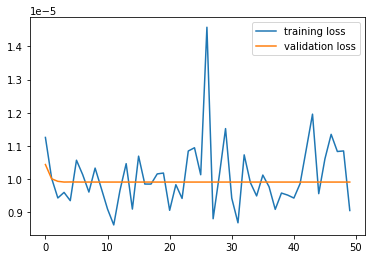

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 67s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 6s 1s/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

Text(0.5, 1.0, 'train dataset')

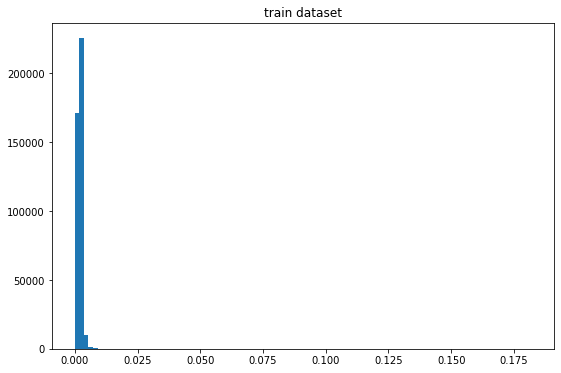

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
# plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.0018195060304249866

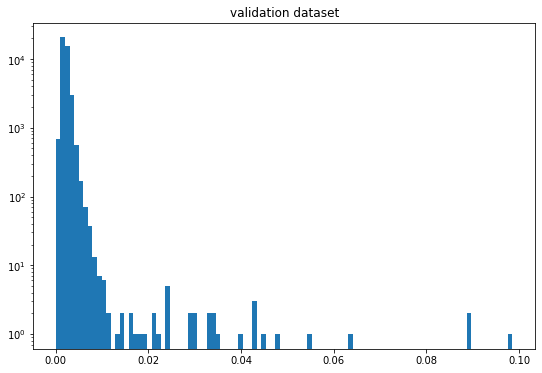

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.0009858735200816455

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([397136, 306080,  78861, ..., 363344, 345370, 362534])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  397136
MAE:  0.18195058523726249
n_bunches       1868
bunch_index     1426
bunch_number     779
Name: 8118219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_09h10m14s.h5


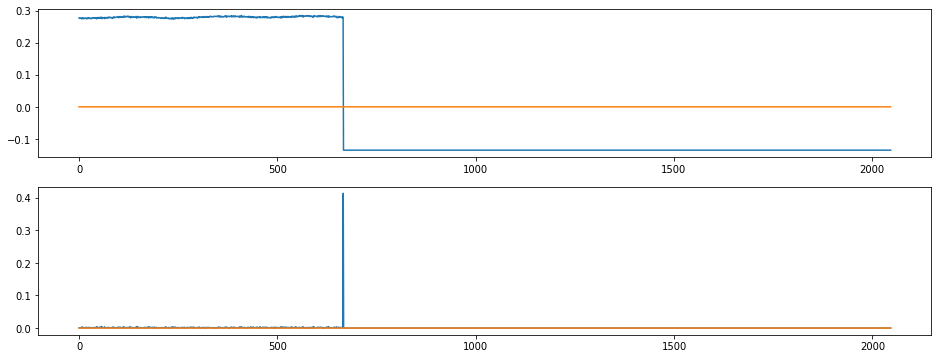

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  397136
MAE:  0.18195058523726249
n_bunches       1868
bunch_index     1426
bunch_number     779
Name: 8118219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_09h10m14s.h5


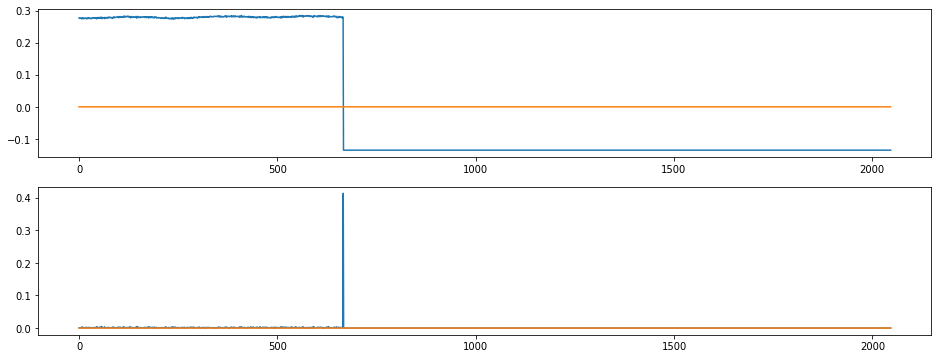

index:  306080
MAE:  0.14443941049031336
n_bunches       2556
bunch_index     3218
bunch_number    2406
Name: 1517855, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_20h31m14s.h5


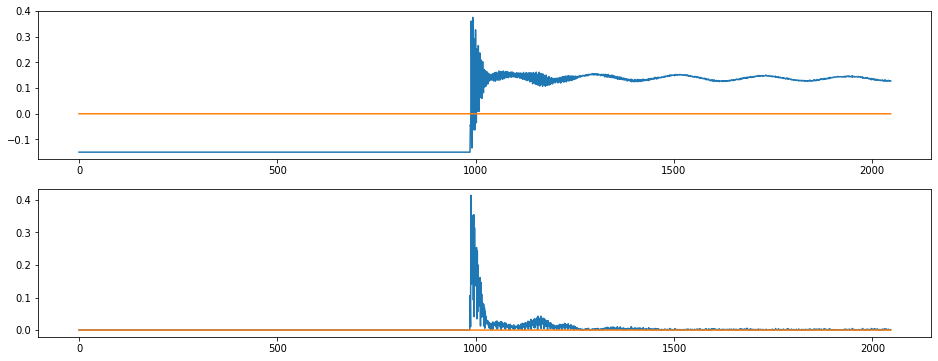

index:  78861
MAE:  0.1328567541903988
n_bunches       670
bunch_index     473
bunch_number     97
Name: 9928776, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_19h50m15s.h5


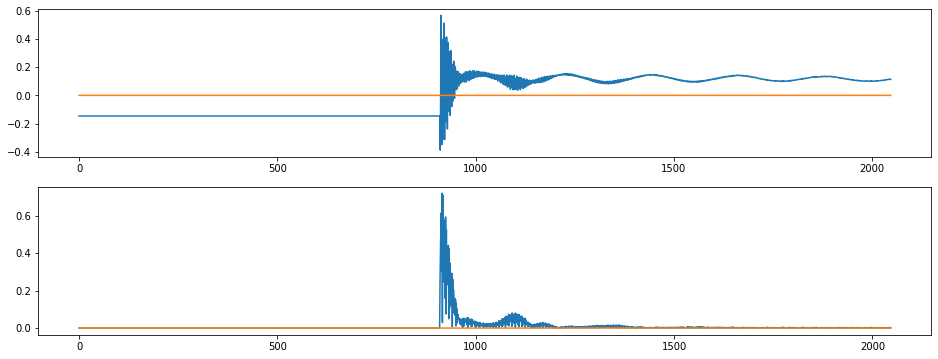

index:  241533
MAE:  0.12326566019277638
n_bunches       2556
bunch_index     1418
bunch_number    1056
Name: 373736, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h49m13s.h5


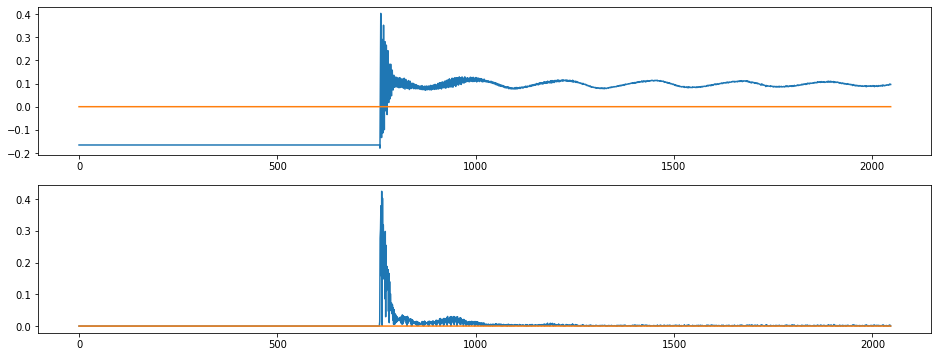

index:  386323
MAE:  0.12055906650391947
n_bunches       1227
bunch_index     2084
bunch_number     784
Name: 10753407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_08h03m14s.h5


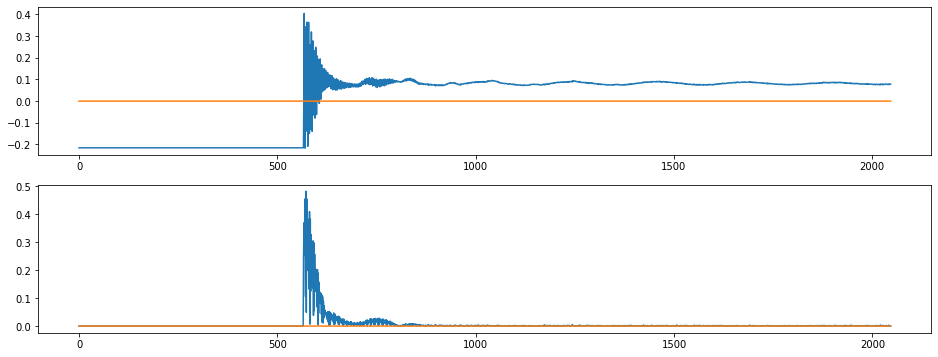

index:  374055
MAE:  0.11244387615600739
n_bunches       924
bunch_index     214
bunch_number    108
Name: 951036, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6675/instability_data/06675_Inst_B1H_Q7_20180512_19h53m08s.h5


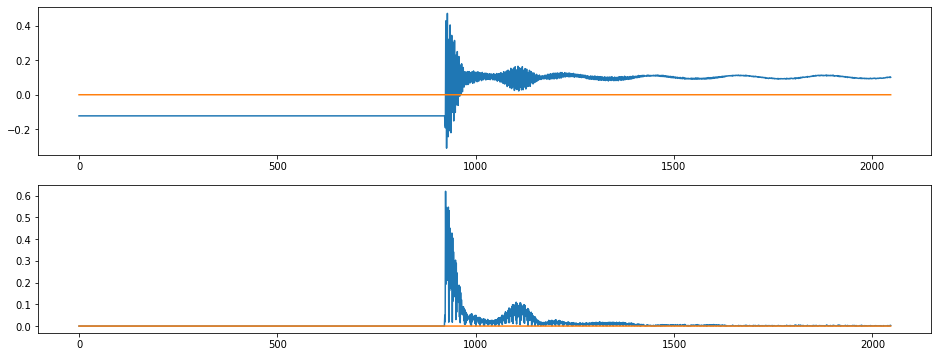

index:  110993
MAE:  0.11115745870166847
n_bunches       1068
bunch_index      913
bunch_number     649
Name: 3705189, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7124/instability_data/07124_Inst_B1H_Q7_20180904_06h56m46s.h5


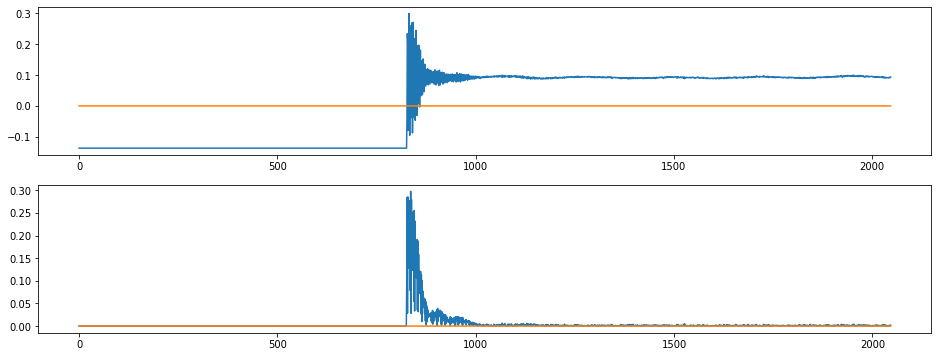

index:  213759
MAE:  0.1094880438546442
n_bunches       108
bunch_index      88
bunch_number     39
Name: 8081445, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6770/instability_data/06770_Inst_B1H_Q7_20180608_21h27m14s.h5


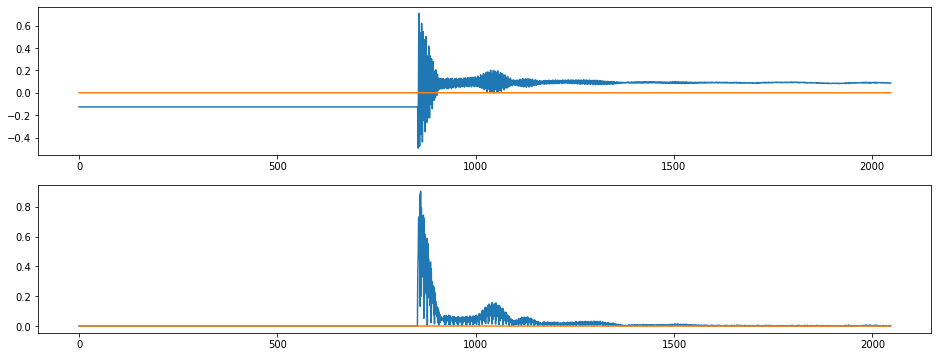

index:  330626
MAE:  0.10725134677816708
n_bunches       924
bunch_index     633
bunch_number    437
Name: 1349158, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h00m42s.h5


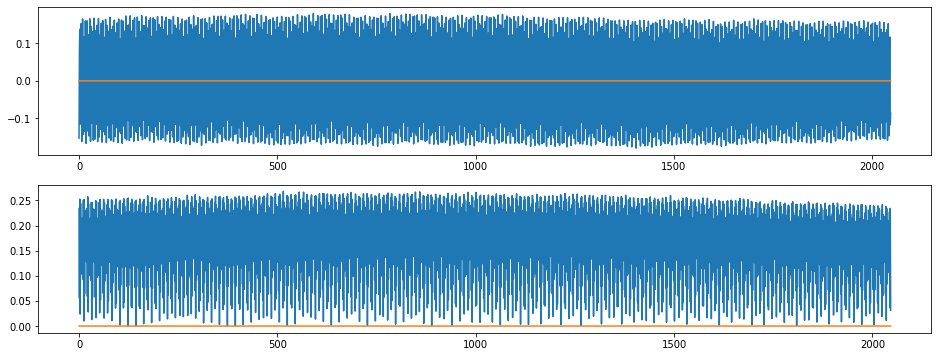

index:  345621
MAE:  0.10714452468808627
n_bunches       540
bunch_index     276
bunch_number    163
Name: 7031173, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6760/instability_data/06760_Inst_B1H_Q7_20180605_15h56m19s.h5


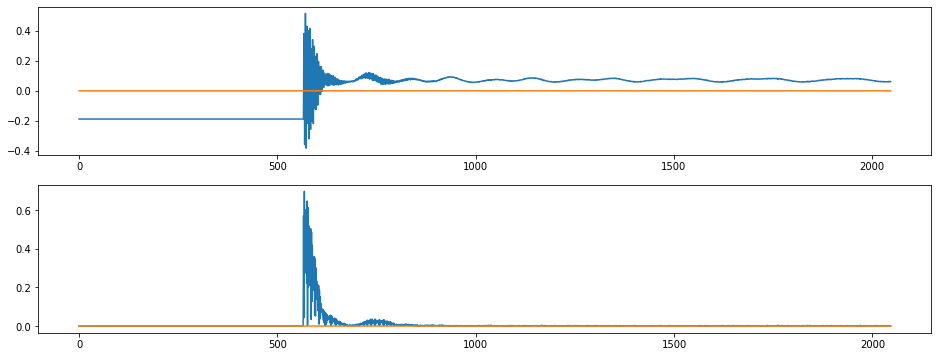

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  362534
MAE:  1.798508703076962e-10
n_bunches       1452
bunch_index     1916
bunch_number     806
Name: 9184809, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_17h42m14s.h5


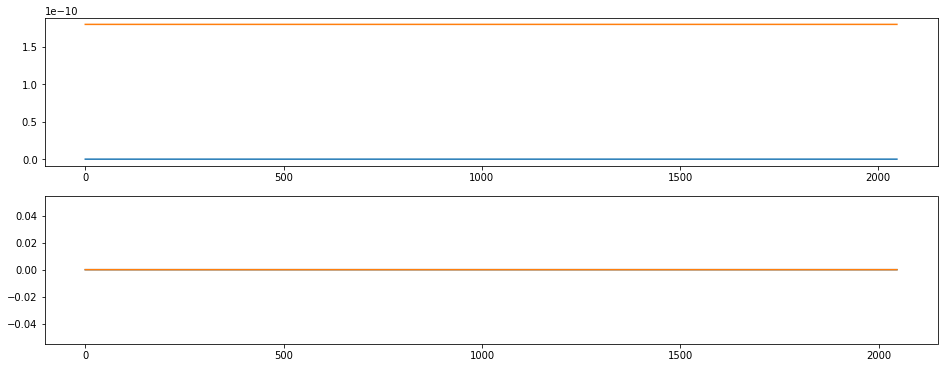

index:  345370
MAE:  1.798508703076962e-10
n_bunches        61
bunch_index     137
bunch_number     28
Name: 7074713, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6995/instability_data/06995_Inst_B1H_Q7_20180728_02h34m14s.h5


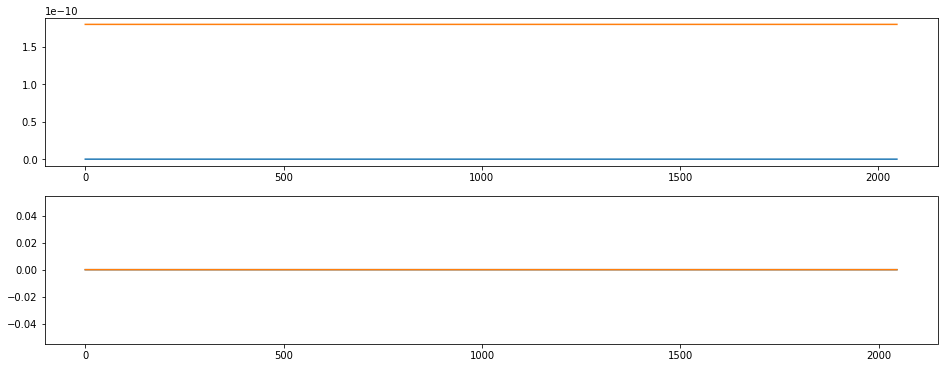

index:  363344
MAE:  1.798508703076962e-10
n_bunches       780
bunch_index     657
bunch_number    473
Name: 7425002, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7265/instability_data/07265_Inst_B1H_Q7_20181007_22h29m02s.h5


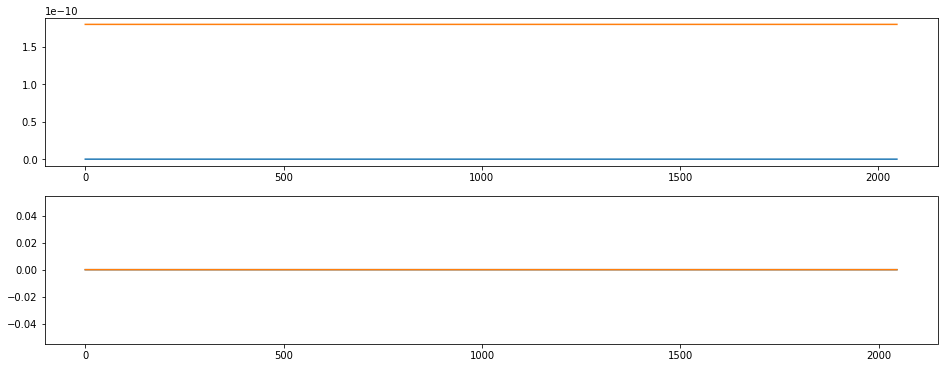

index:  335307
MAE:  1.798508703076962e-10
n_bunches       300
bunch_index     461
bunch_number    226
Name: 4945336, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6809/instability_data/06809_Inst_B1H_Q7_20180616_05h58m36s.h5


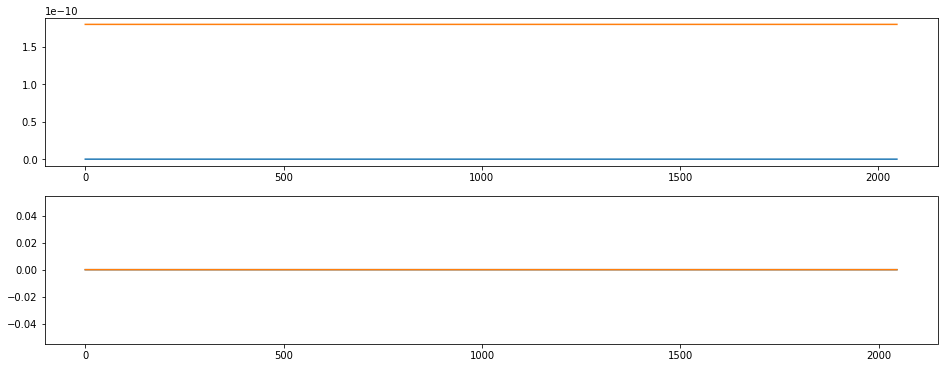

index:  59735
MAE:  1.798508703076962e-10
n_bunches        355
bunch_index     1152
bunch_number     240
Name: 605157, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7479/instability_data/07479_Inst_B1H_Q7_20181127_21h27m42s.h5


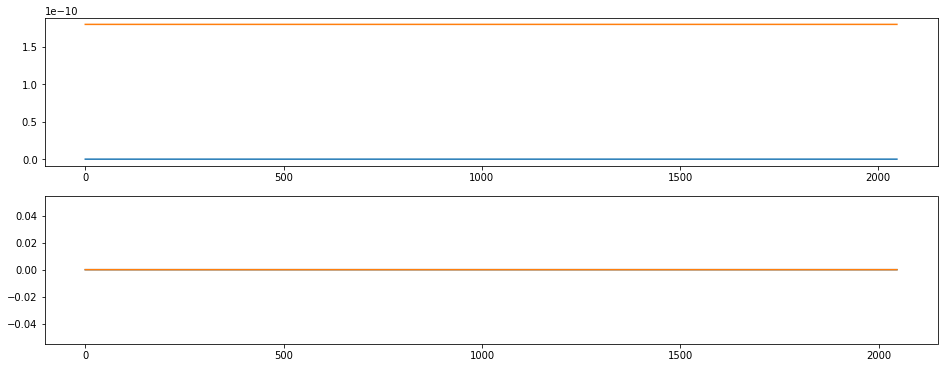

index:  328343
MAE:  1.798508703076962e-10
n_bunches       2556
bunch_index      490
bunch_number     332
Name: 2944692, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_10h03m14s.h5


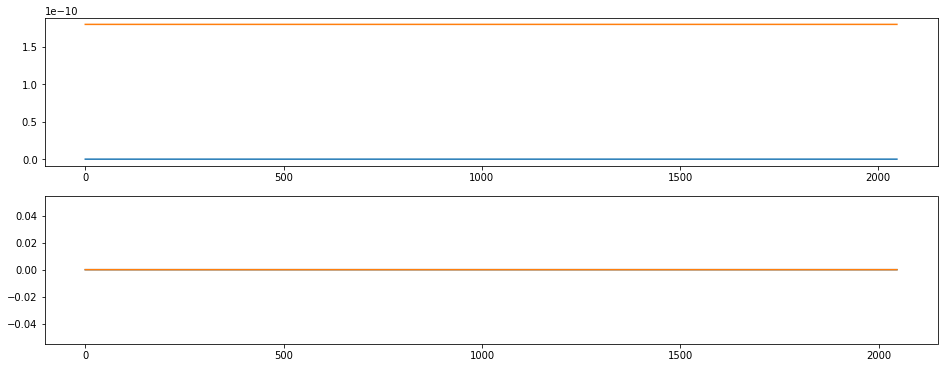

index:  390045
MAE:  1.798508703076962e-10
n_bunches       1188
bunch_index     2235
bunch_number    1113
Name: 10403225, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6170/instability_data/06170_Inst_B1H_Q7_20170905_19h51m48s.h5


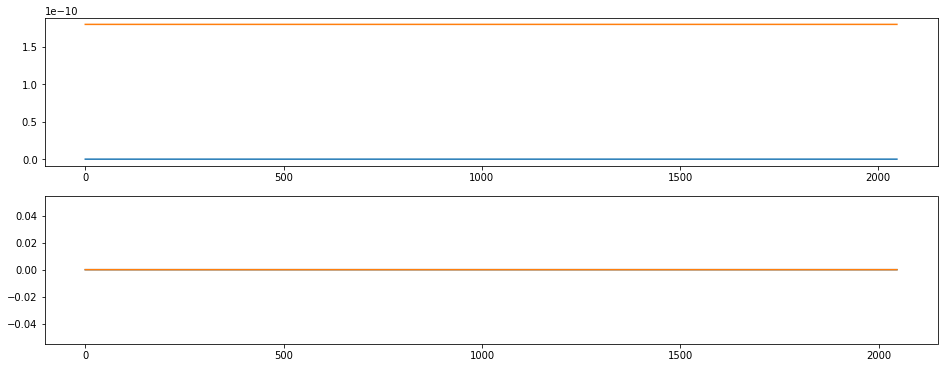

index:  392271
MAE:  1.798508703076962e-10
n_bunches        924
bunch_index     1053
bunch_number     775
Name: 2095950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6938/instability_data/06938_Inst_B1H_Q7_20180717_21h19m36s.h5


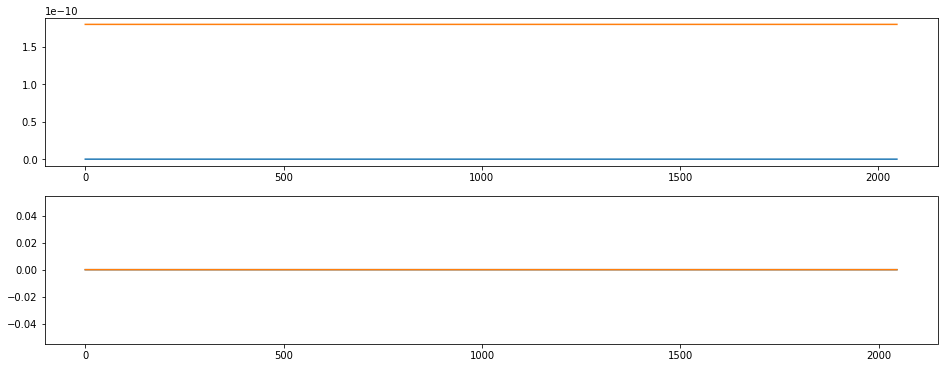

index:  375778
MAE:  1.798508703076962e-10
n_bunches       312
bunch_index     507
bunch_number    226
Name: 10896396, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6854/instability_data/06854_Inst_B1H_Q7_20180627_21h37m01s.h5


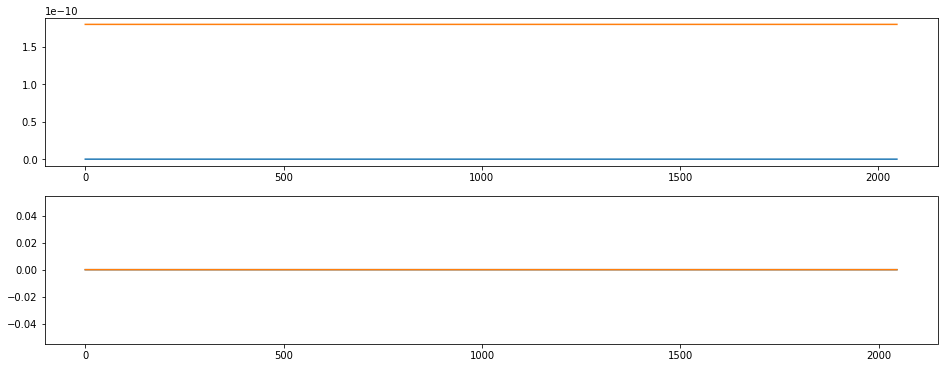

index:  363832
MAE:  1.798508703076962e-10
n_bunches       444
bunch_index     585
bunch_number    312
Name: 7610678, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h51m14s.h5


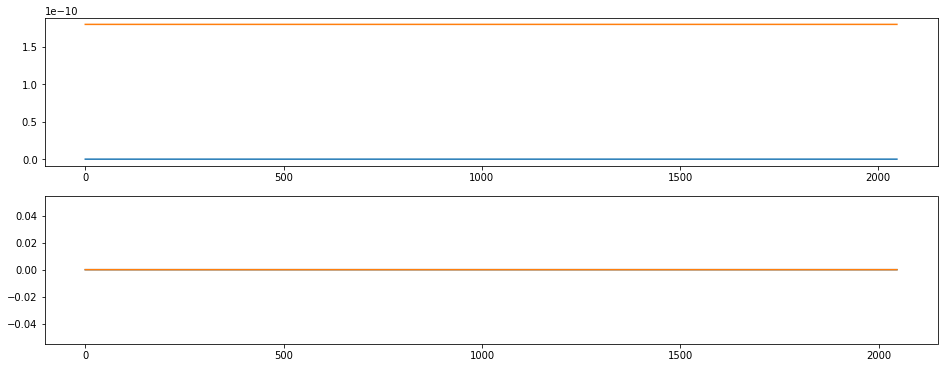

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  250805
MAE:  0.0018195079789415946
n_bunches       2460
bunch_index      590
bunch_number     431
Name: 3980256, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_17h33m19s.h5


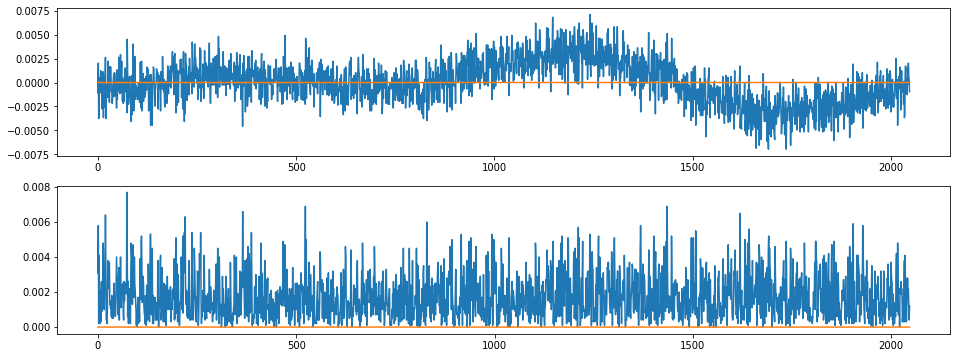

index:  155318
MAE:  0.0018195079842106632
n_bunches       672
bunch_index     377
bunch_number     77
Name: 9199649, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6585/instability_data/06585_Inst_B1H_Q7_20180421_12h50m14s.h5


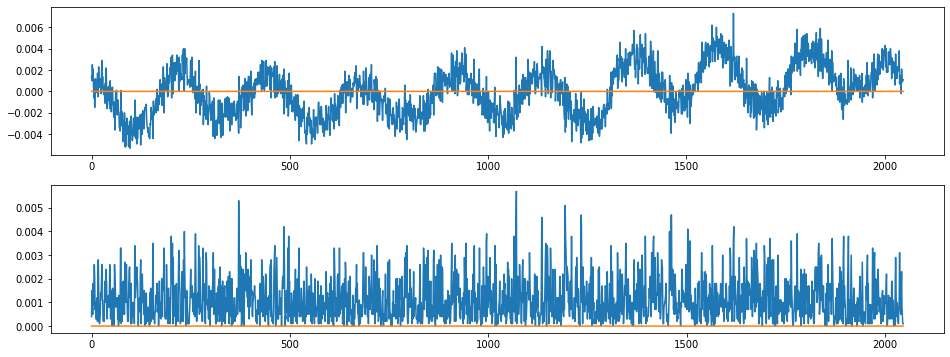

index:  44923
MAE:  0.0018195162442072726
n_bunches        733
bunch_index     2333
bunch_number     495
Name: 8268520, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_09h50m15s.h5


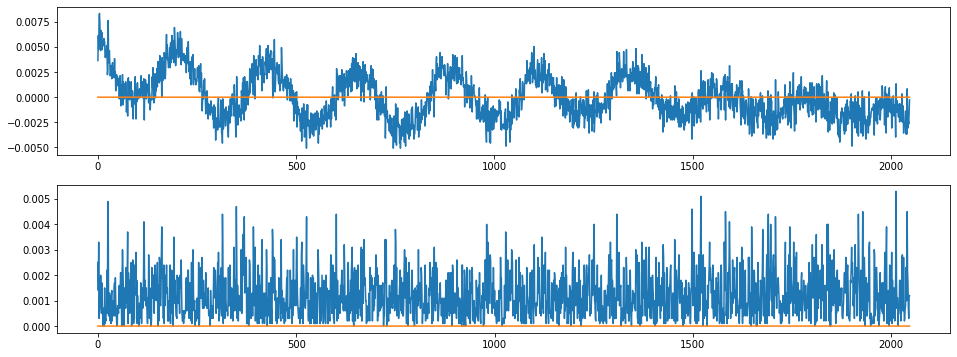

index:  49837
MAE:  0.0018195177159039454
n_bunches       444
bunch_index     282
bunch_number     92
Name: 7363367, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h58m14s.h5


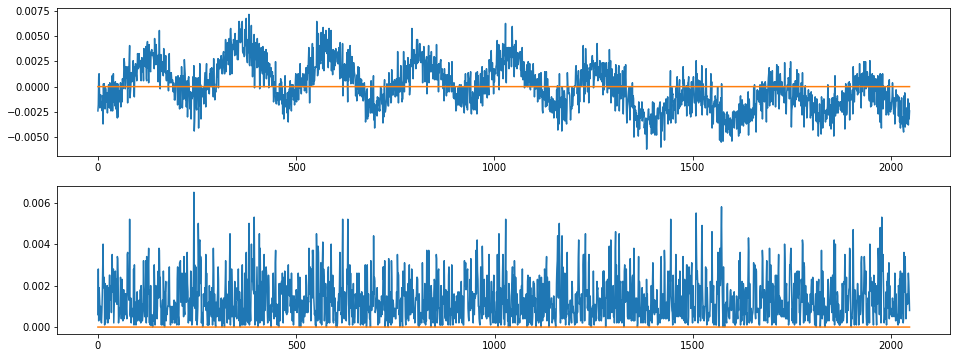

index:  310913
MAE:  0.001819491576445895
n_bunches       1212
bunch_index      415
bunch_number     283
Name: 8245723, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7097/instability_data/07097_Inst_B1H_Q7_20180828_14h29m47s.h5


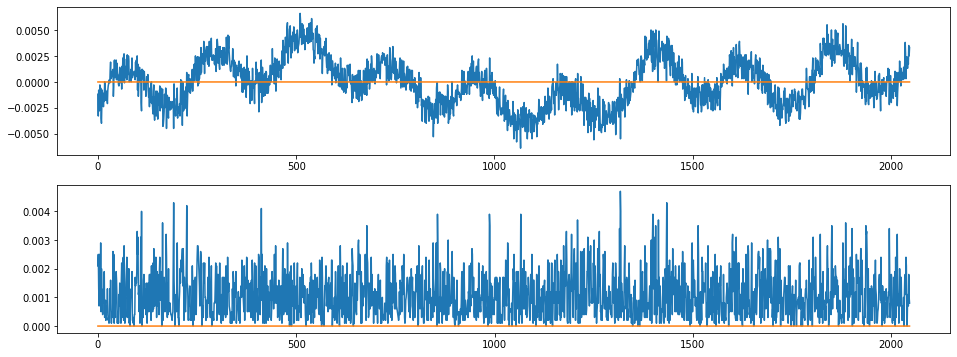

index:  230376
MAE:  0.0018194912083244752
n_bunches       172
bunch_index     260
bunch_number    134
Name: 9504290, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6411/instability_data/06411_Inst_B1H_Q7_20171122_21h27m14s.h5


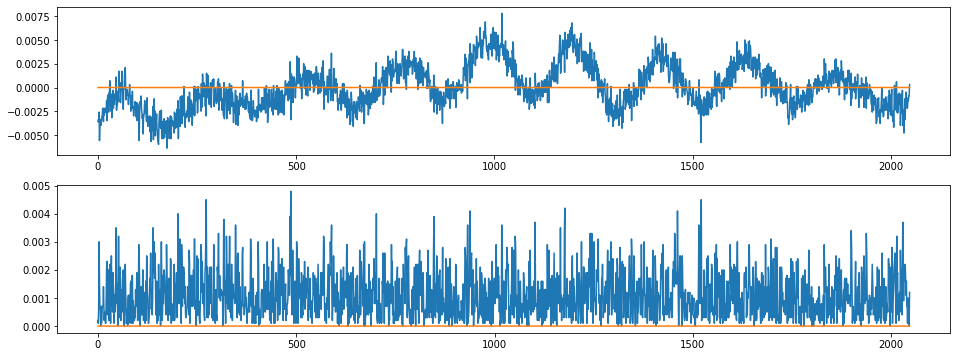

index:  39889
MAE:  0.0018195228611787278
n_bunches        300
bunch_index     2222
bunch_number     251
Name: 8794422, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7392/instability_data/07392_Inst_B1H_Q7_20181030_19h15m11s.h5


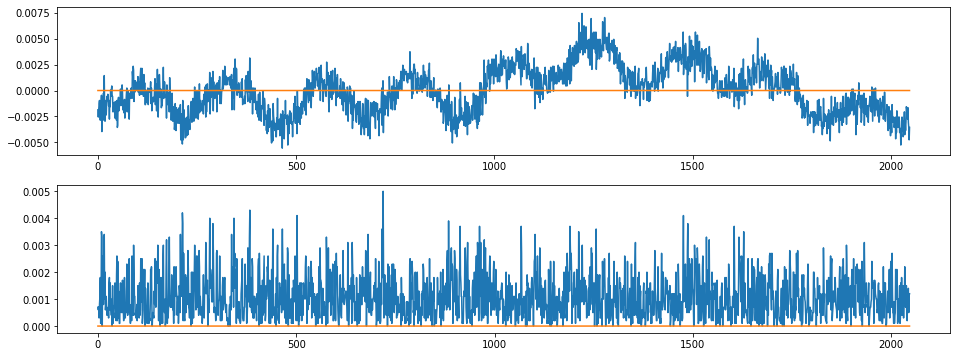

index:  229250
MAE:  0.001819522996677544
n_bunches        670
bunch_index     2303
bunch_number     487
Name: 5533976, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_23h02m16s.h5


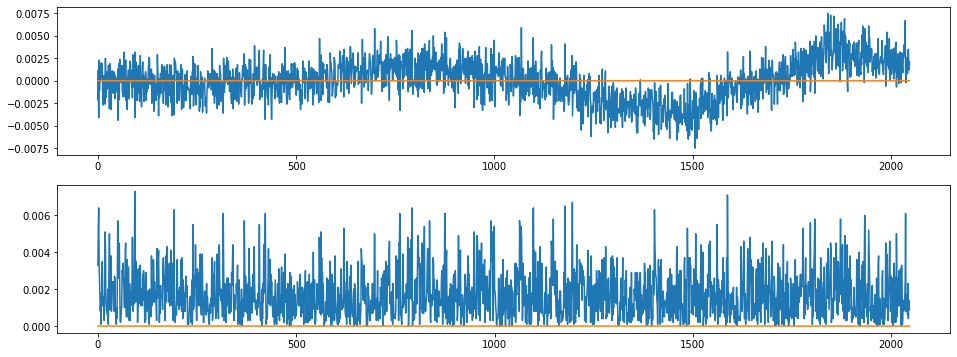

index:  352930
MAE:  0.001819489050789677
n_bunches       2556
bunch_index     1858
bunch_number    1365
Name: 2578532, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7347/instability_data/07347_Inst_B1H_Q7_20181025_11h49m37s.h5


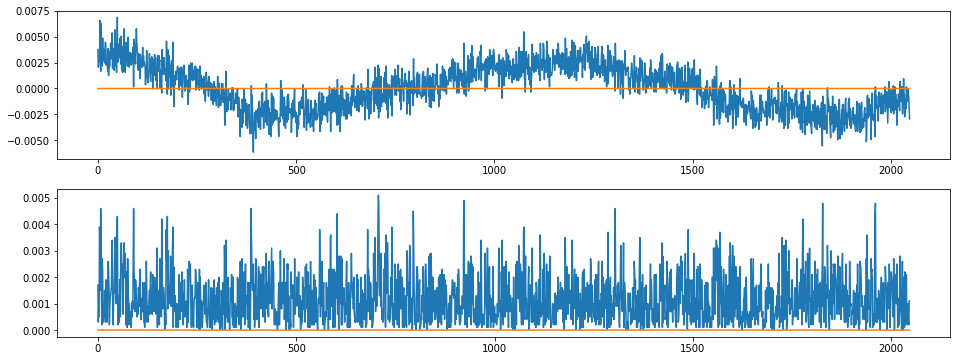

index:  372266
MAE:  0.0018194834195446841
n_bunches       2556
bunch_index     2008
bunch_number    1458
Name: 2211635, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_13h47m14s.h5


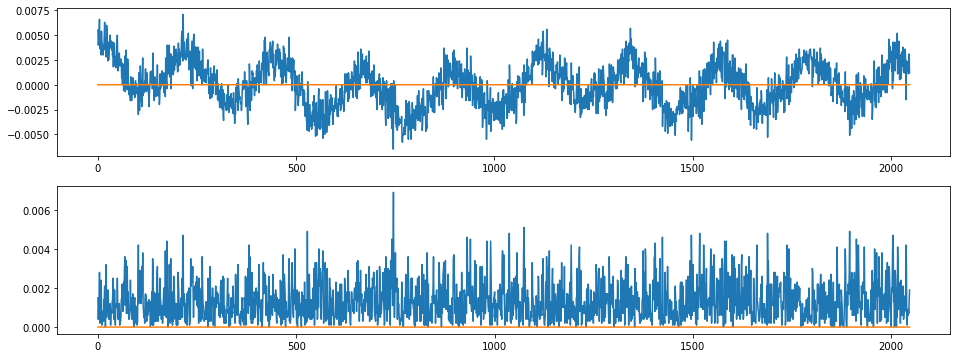

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  397136
MAE:  0.18195058523726249
n_bunches       1868
bunch_index     1426
bunch_number     779
Name: 8118219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_09h10m14s.h5


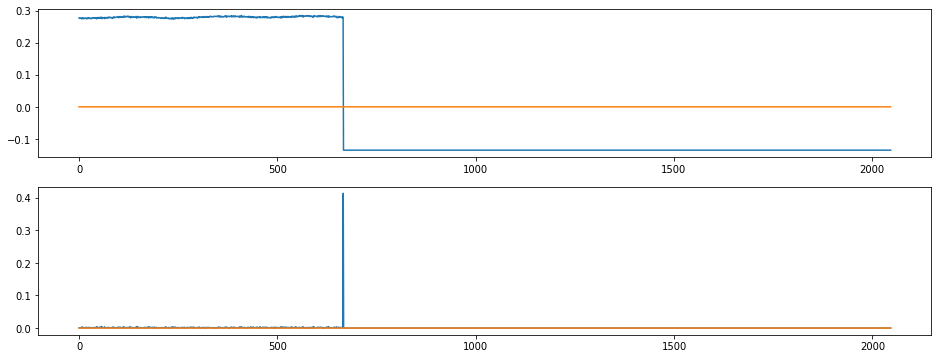

index:  306080
MAE:  0.14443941049031336
n_bunches       2556
bunch_index     3218
bunch_number    2406
Name: 1517855, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_20h31m14s.h5


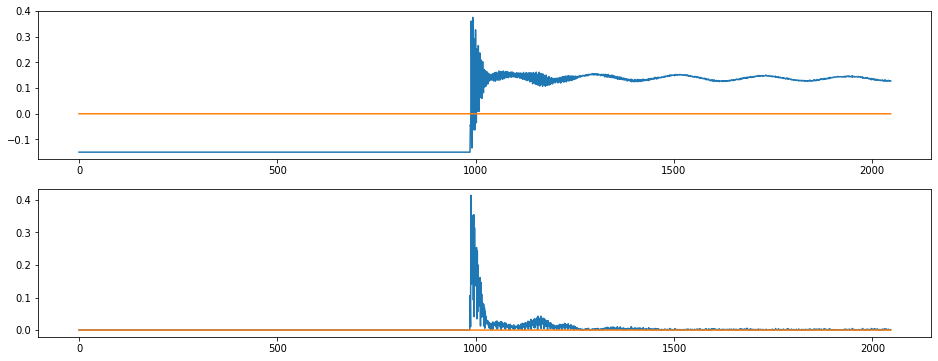

index:  78861
MAE:  0.1328567541903988
n_bunches       670
bunch_index     473
bunch_number     97
Name: 9928776, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_19h50m15s.h5


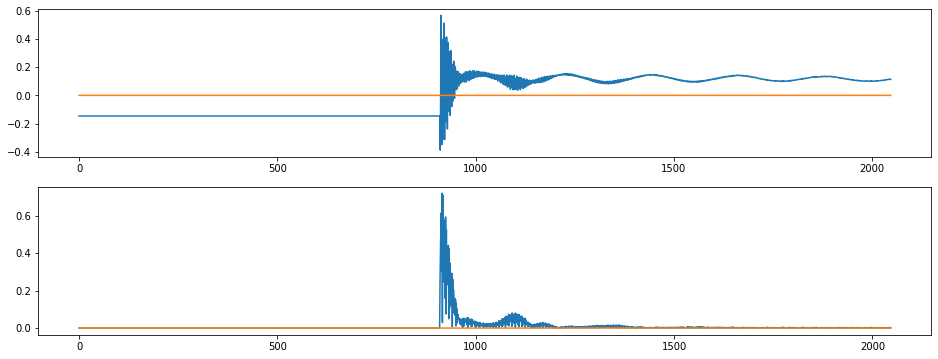

index:  241533
MAE:  0.12326566019277638
n_bunches       2556
bunch_index     1418
bunch_number    1056
Name: 373736, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h49m13s.h5


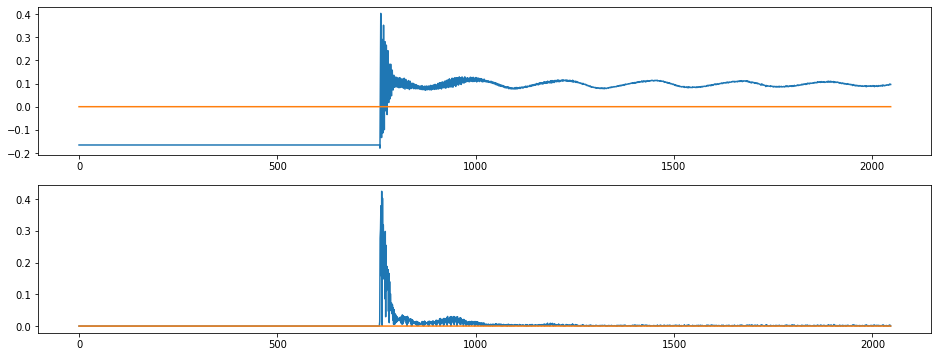

index:  386323
MAE:  0.12055906650391947
n_bunches       1227
bunch_index     2084
bunch_number     784
Name: 10753407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_08h03m14s.h5


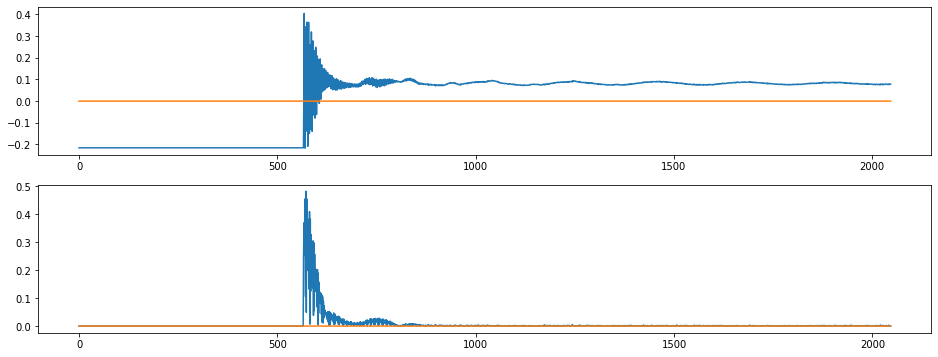

index:  374055
MAE:  0.11244387615600739
n_bunches       924
bunch_index     214
bunch_number    108
Name: 951036, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6675/instability_data/06675_Inst_B1H_Q7_20180512_19h53m08s.h5


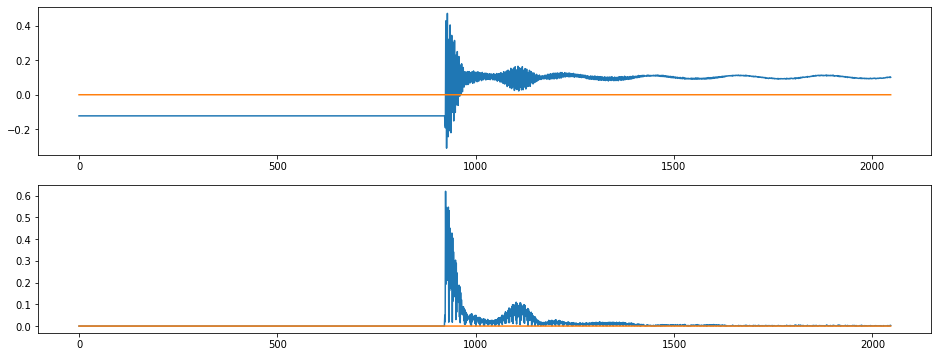

index:  110993
MAE:  0.11115745870166847
n_bunches       1068
bunch_index      913
bunch_number     649
Name: 3705189, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7124/instability_data/07124_Inst_B1H_Q7_20180904_06h56m46s.h5


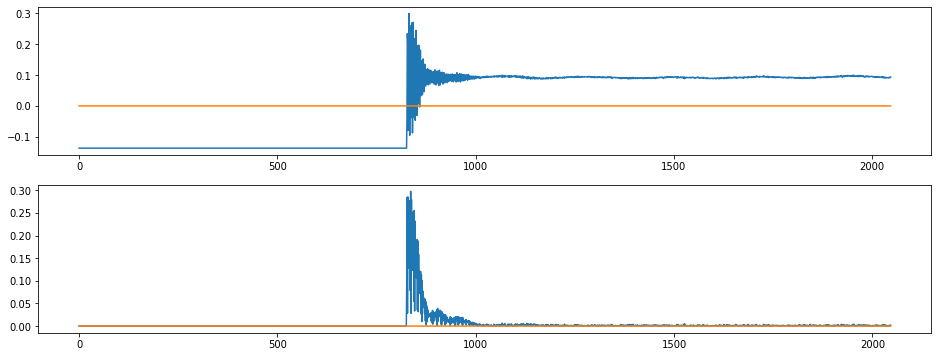

index:  213759
MAE:  0.1094880438546442
n_bunches       108
bunch_index      88
bunch_number     39
Name: 8081445, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6770/instability_data/06770_Inst_B1H_Q7_20180608_21h27m14s.h5


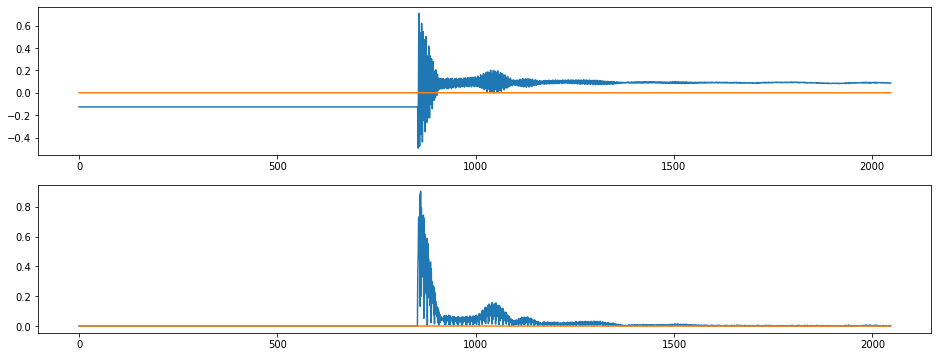

index:  330626
MAE:  0.10725134677816708
n_bunches       924
bunch_index     633
bunch_number    437
Name: 1349158, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h00m42s.h5


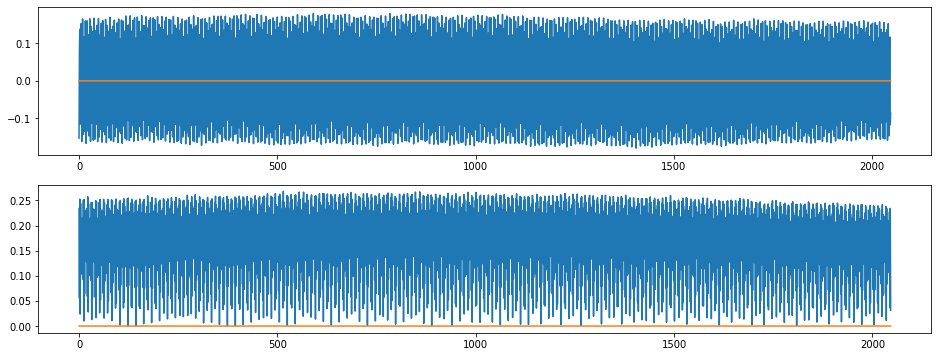

index:  345621
MAE:  0.10714452468808627
n_bunches       540
bunch_index     276
bunch_number    163
Name: 7031173, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6760/instability_data/06760_Inst_B1H_Q7_20180605_15h56m19s.h5


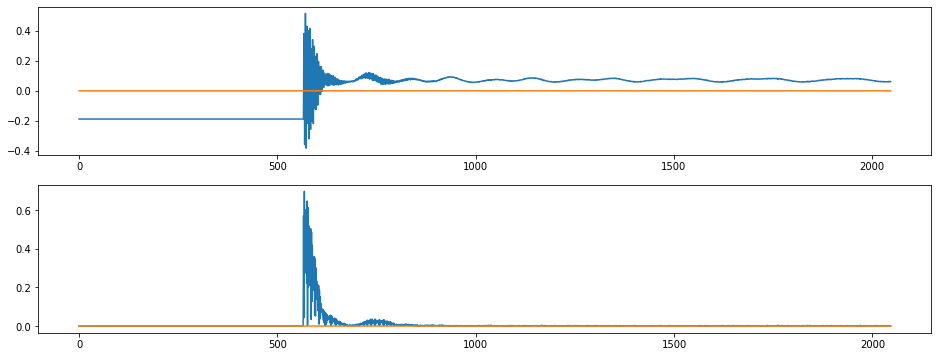

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

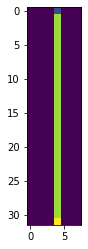

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  362534
MAE:  1.798508703076962e-10
n_bunches       1452
bunch_index     1916
bunch_number     806
Name: 9184809, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_17h42m14s.h5


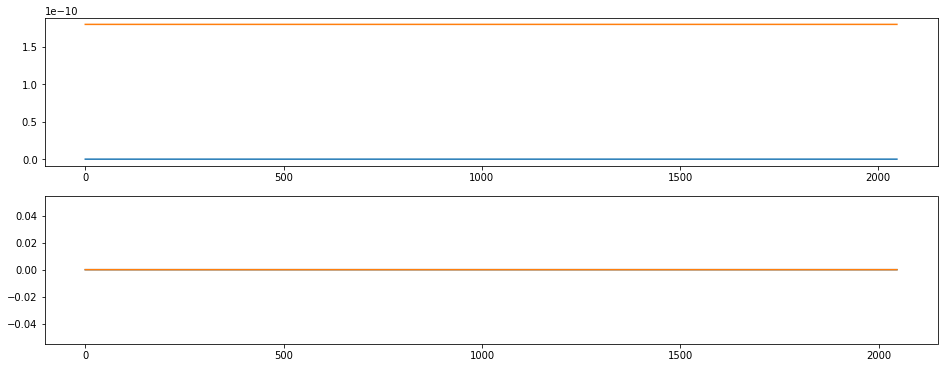

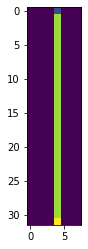

index:  345370
MAE:  1.798508703076962e-10
n_bunches        61
bunch_index     137
bunch_number     28
Name: 7074713, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6995/instability_data/06995_Inst_B1H_Q7_20180728_02h34m14s.h5


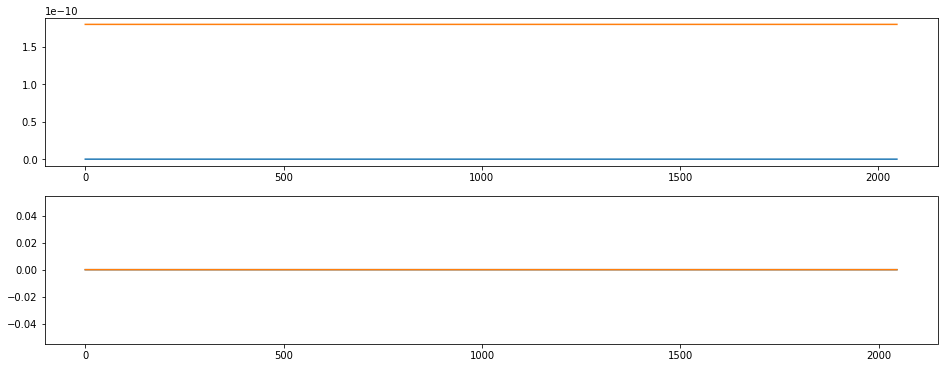

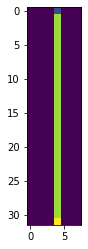

index:  363344
MAE:  1.798508703076962e-10
n_bunches       780
bunch_index     657
bunch_number    473
Name: 7425002, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7265/instability_data/07265_Inst_B1H_Q7_20181007_22h29m02s.h5


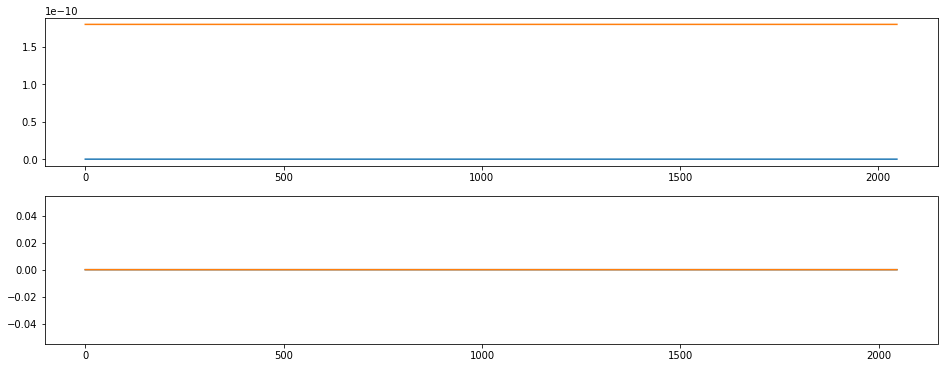

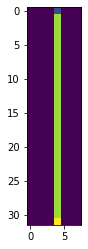

index:  335307
MAE:  1.798508703076962e-10
n_bunches       300
bunch_index     461
bunch_number    226
Name: 4945336, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6809/instability_data/06809_Inst_B1H_Q7_20180616_05h58m36s.h5


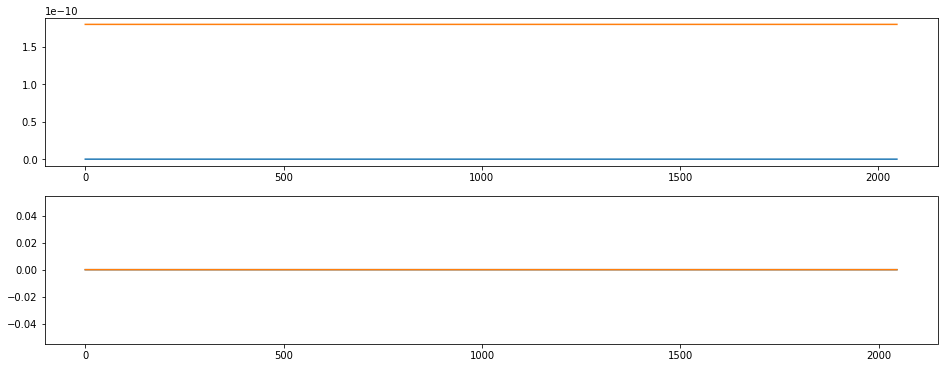

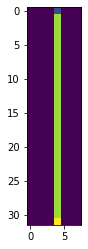

index:  59735
MAE:  1.798508703076962e-10
n_bunches        355
bunch_index     1152
bunch_number     240
Name: 605157, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7479/instability_data/07479_Inst_B1H_Q7_20181127_21h27m42s.h5


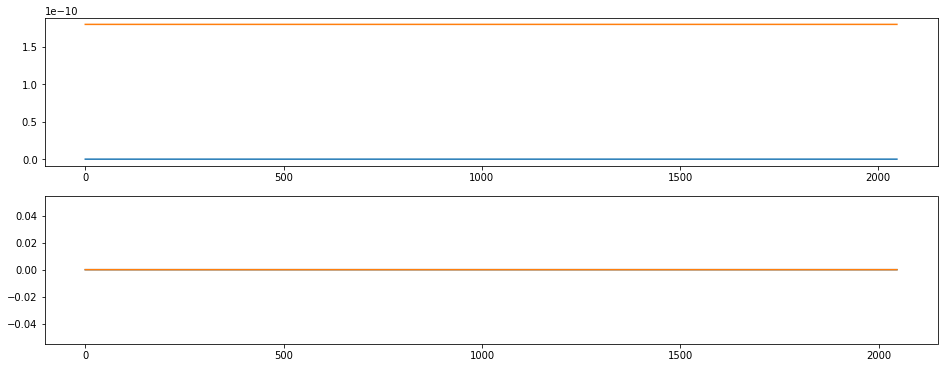

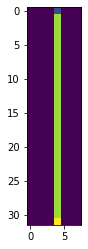

index:  328343
MAE:  1.798508703076962e-10
n_bunches       2556
bunch_index      490
bunch_number     332
Name: 2944692, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_10h03m14s.h5


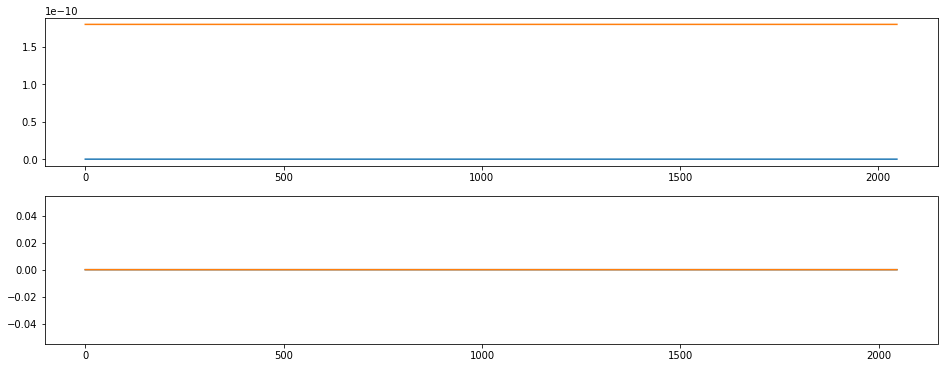

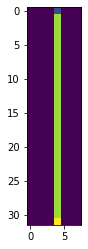

index:  390045
MAE:  1.798508703076962e-10
n_bunches       1188
bunch_index     2235
bunch_number    1113
Name: 10403225, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6170/instability_data/06170_Inst_B1H_Q7_20170905_19h51m48s.h5


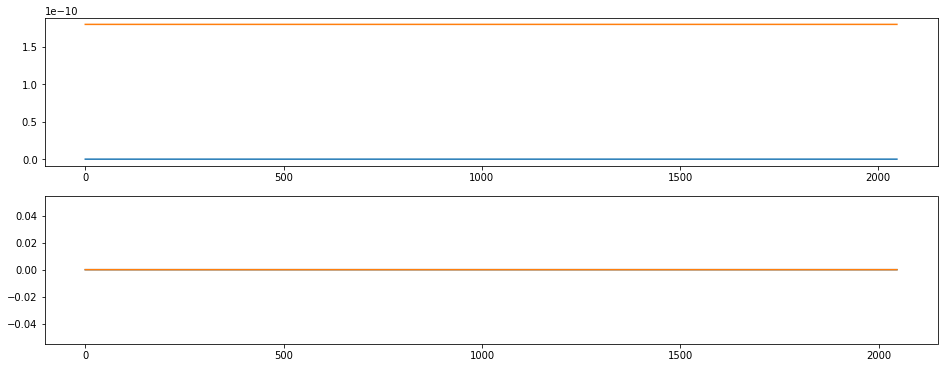

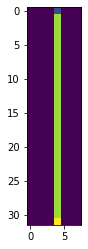

index:  392271
MAE:  1.798508703076962e-10
n_bunches        924
bunch_index     1053
bunch_number     775
Name: 2095950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6938/instability_data/06938_Inst_B1H_Q7_20180717_21h19m36s.h5


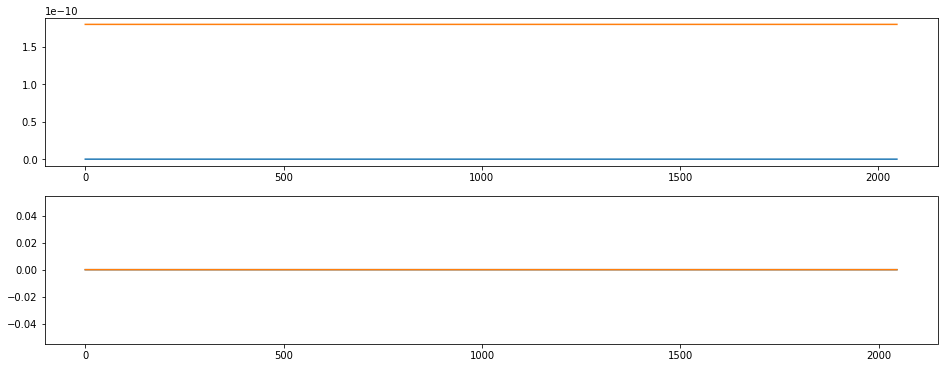

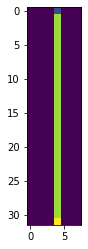

index:  375778
MAE:  1.798508703076962e-10
n_bunches       312
bunch_index     507
bunch_number    226
Name: 10896396, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6854/instability_data/06854_Inst_B1H_Q7_20180627_21h37m01s.h5


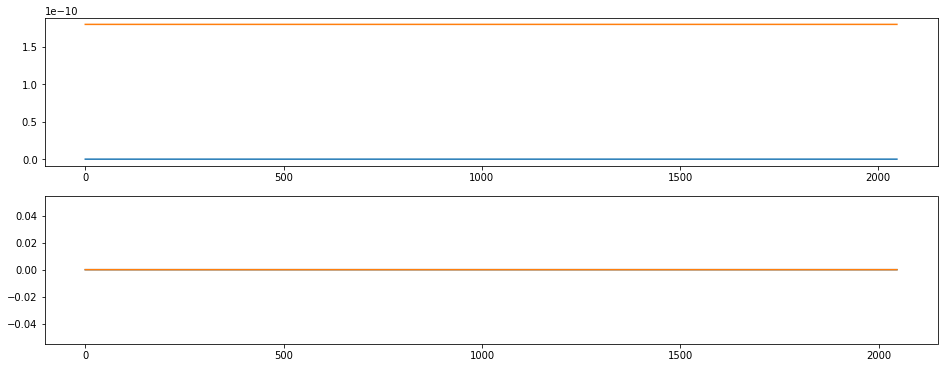

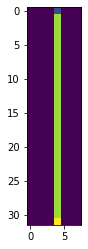

index:  363832
MAE:  1.798508703076962e-10
n_bunches       444
bunch_index     585
bunch_number    312
Name: 7610678, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h51m14s.h5


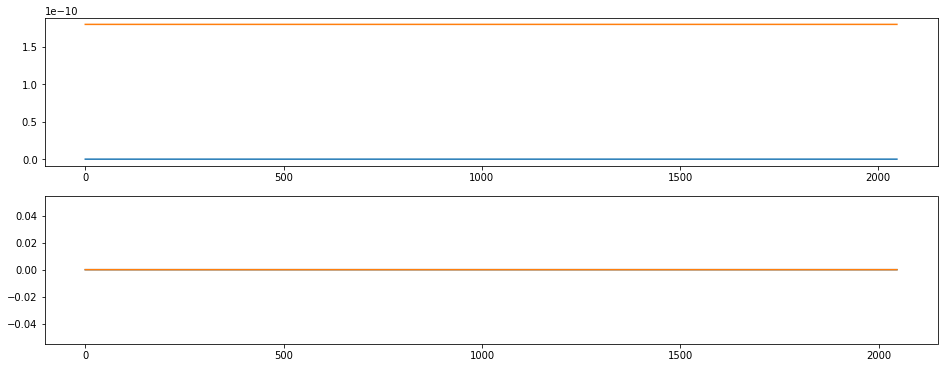

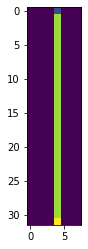

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  397136
MAE:  0.18195058523726249
n_bunches       1868
bunch_index     1426
bunch_number     779
Name: 8118219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_09h10m14s.h5


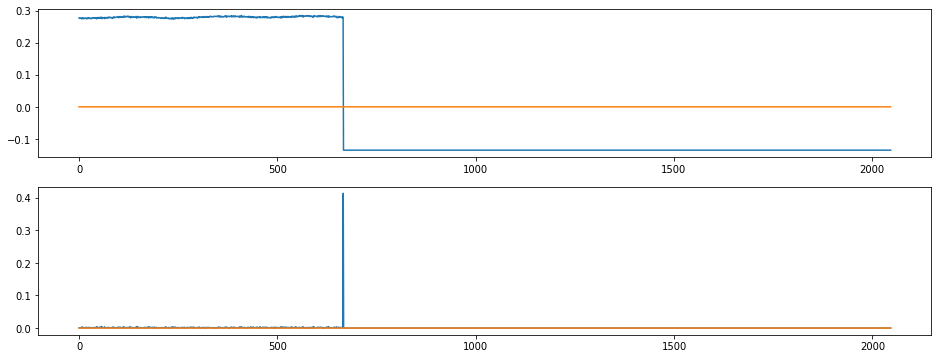

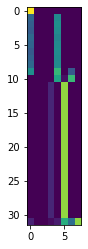

index:  306080
MAE:  0.14443941049031336
n_bunches       2556
bunch_index     3218
bunch_number    2406
Name: 1517855, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_20h31m14s.h5


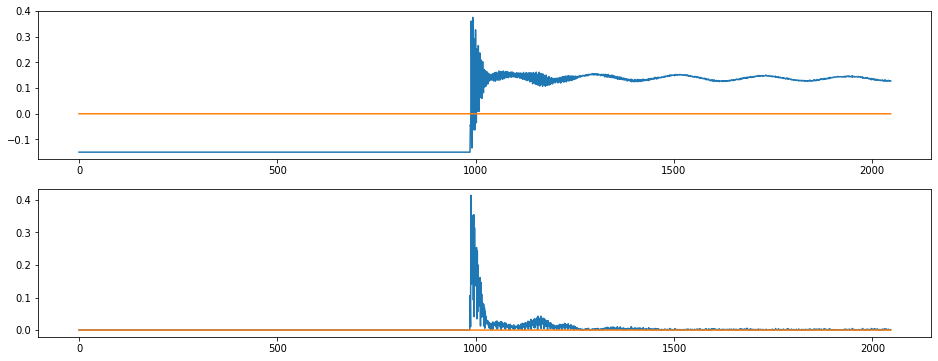

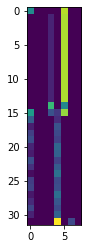

index:  78861
MAE:  0.1328567541903988
n_bunches       670
bunch_index     473
bunch_number     97
Name: 9928776, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_19h50m15s.h5


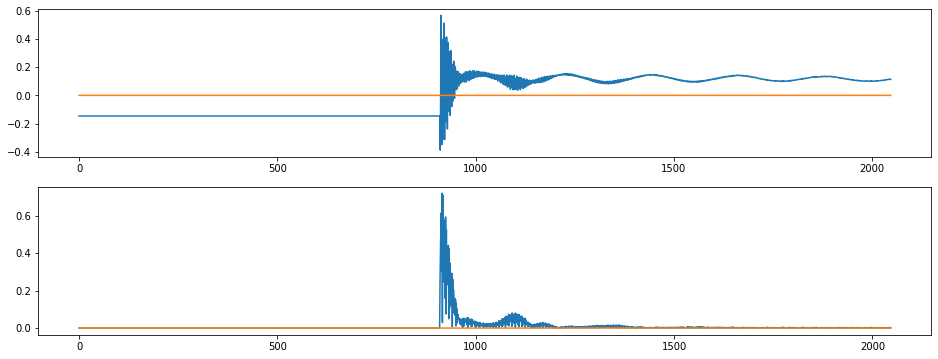

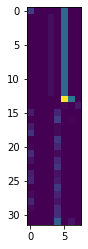

index:  241533
MAE:  0.12326566019277638
n_bunches       2556
bunch_index     1418
bunch_number    1056
Name: 373736, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h49m13s.h5


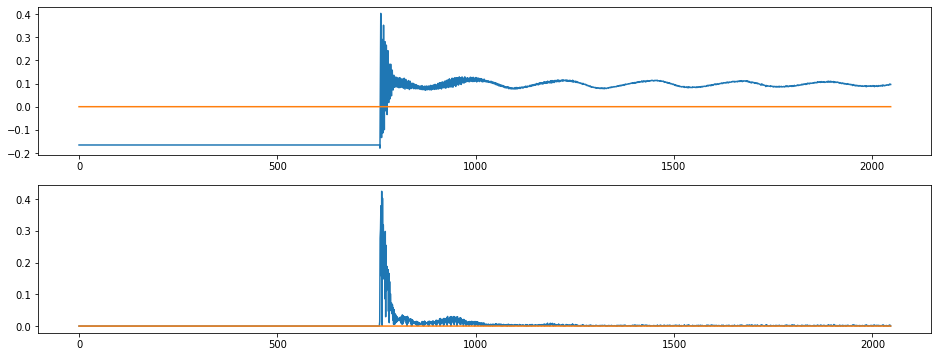

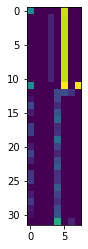

index:  386323
MAE:  0.12055906650391947
n_bunches       1227
bunch_index     2084
bunch_number     784
Name: 10753407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_08h03m14s.h5


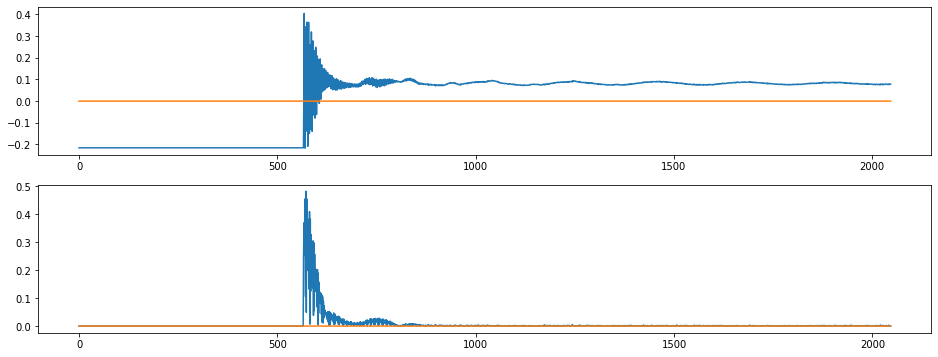

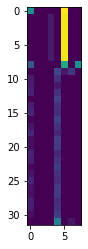

index:  374055
MAE:  0.11244387615600739
n_bunches       924
bunch_index     214
bunch_number    108
Name: 951036, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6675/instability_data/06675_Inst_B1H_Q7_20180512_19h53m08s.h5


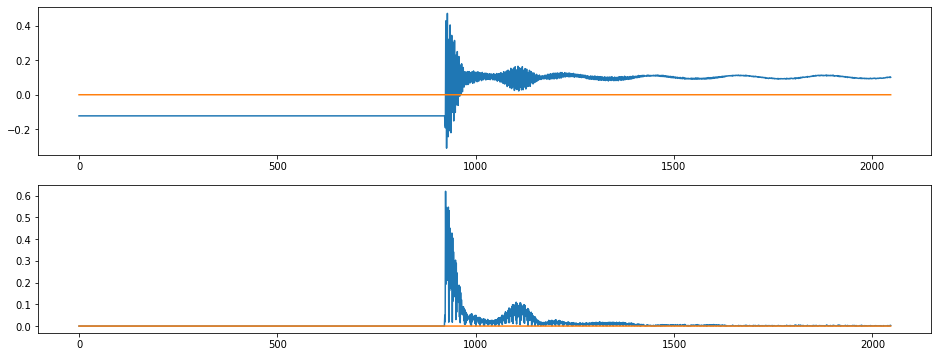

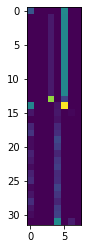

index:  110993
MAE:  0.11115745870166847
n_bunches       1068
bunch_index      913
bunch_number     649
Name: 3705189, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7124/instability_data/07124_Inst_B1H_Q7_20180904_06h56m46s.h5


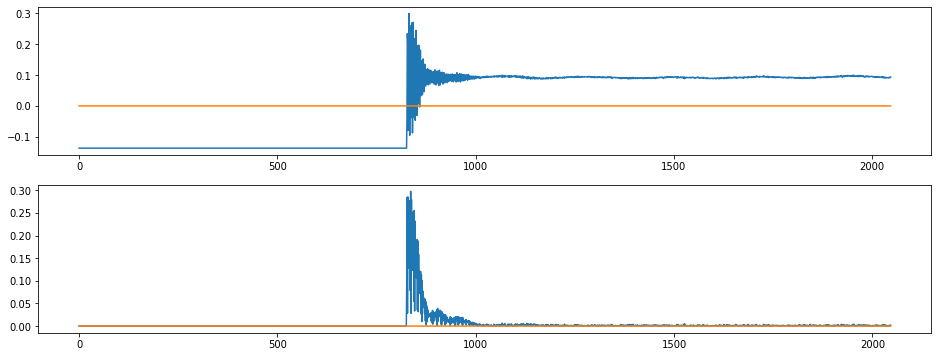

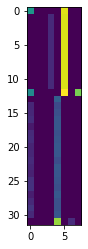

index:  213759
MAE:  0.1094880438546442
n_bunches       108
bunch_index      88
bunch_number     39
Name: 8081445, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6770/instability_data/06770_Inst_B1H_Q7_20180608_21h27m14s.h5


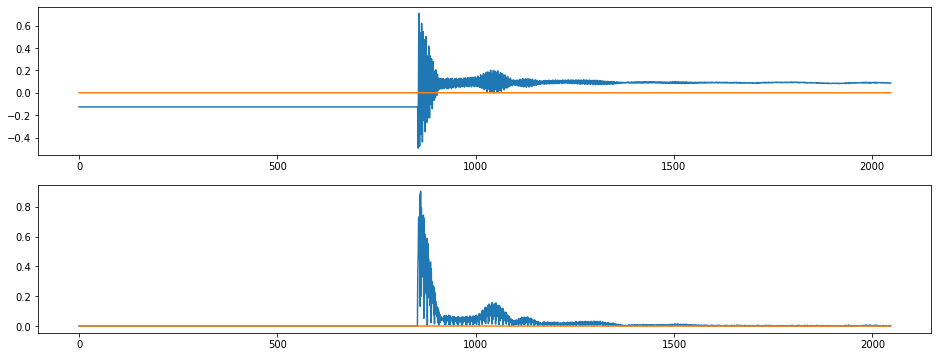

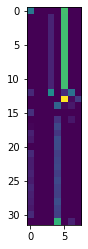

index:  330626
MAE:  0.10725134677816708
n_bunches       924
bunch_index     633
bunch_number    437
Name: 1349158, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h00m42s.h5


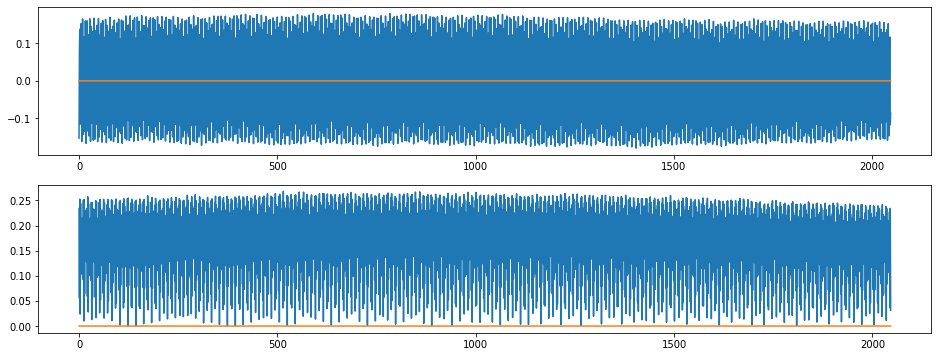

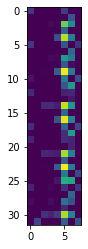

index:  345621
MAE:  0.10714452468808627
n_bunches       540
bunch_index     276
bunch_number    163
Name: 7031173, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6760/instability_data/06760_Inst_B1H_Q7_20180605_15h56m19s.h5


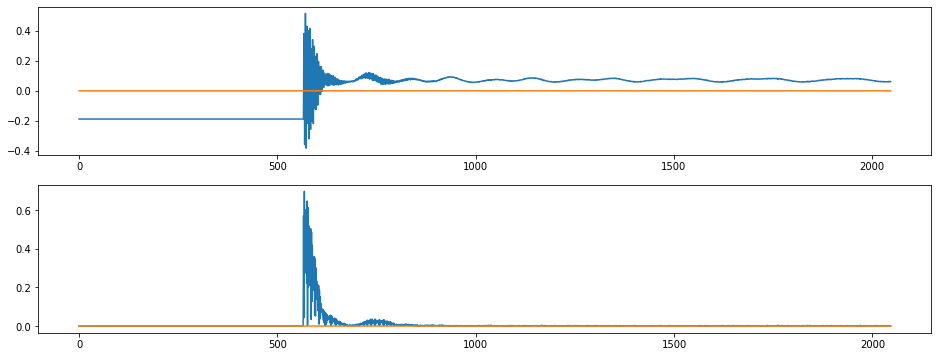

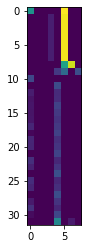

index:  357349
MAE:  0.10398679804213427
n_bunches       1836
bunch_index     1817
bunch_number     970
Name: 8440795, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_09h51m14s.h5


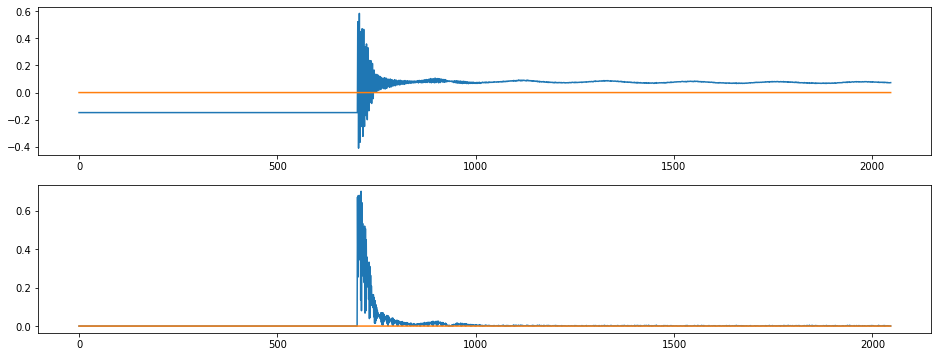

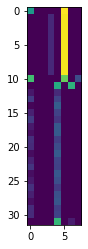

index:  250706
MAE:  0.10322380046282717
n_bunches       636
bunch_index     797
bunch_number    571
Name: 8135049, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6917/instability_data/06917_Inst_B1H_Q7_20180713_00h03m31s.h5


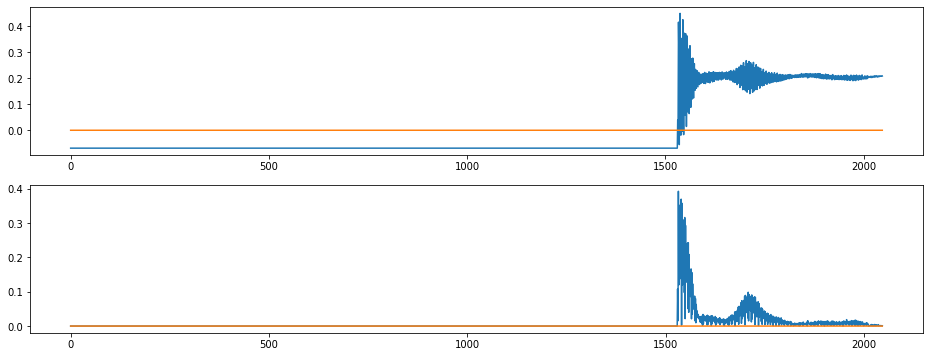

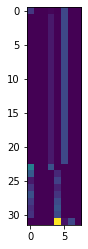

index:  273344
MAE:  0.10279136547418927
n_bunches       987
bunch_index     257
bunch_number     86
Name: 1514356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_19h06m14s.h5


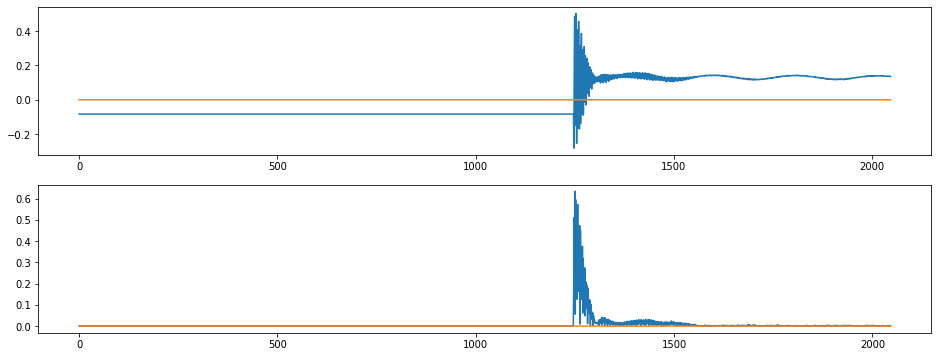

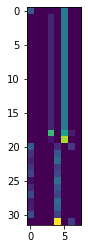

index:  391296
MAE:  0.1016637112633327
n_bunches        524
bunch_index     1954
bunch_number     280
Name: 11245485, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6381/instability_data/06381_Inst_B1H_Q7_20171112_08h01m14s.h5


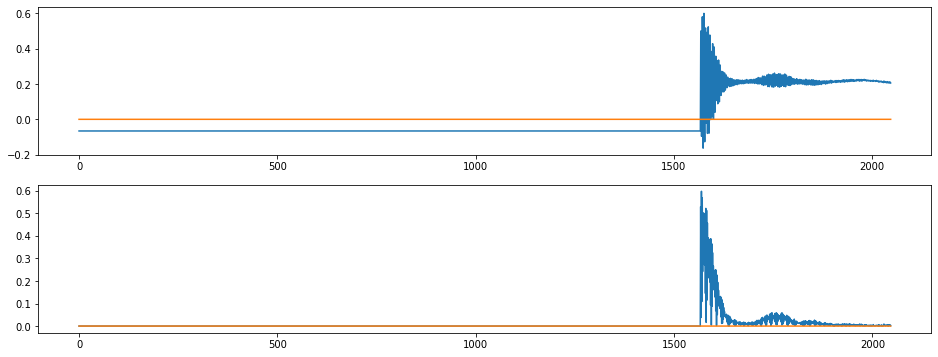

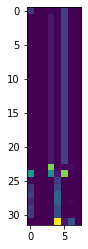

index:  161996
MAE:  0.09525397902852031
n_bunches        656
bunch_index     3198
bunch_number     613
Name: 8068875, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_17h13m15s.h5


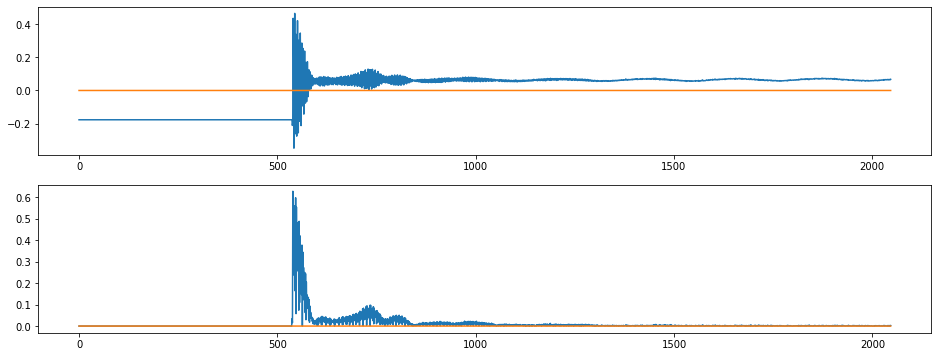

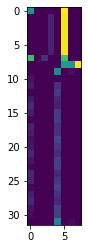

index:  60739
MAE:  0.09490344024187392
n_bunches       1068
bunch_index     1209
bunch_number     886
Name: 2554860, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6924/instability_data/06924_Inst_B1H_Q7_20180715_08h18m14s.h5


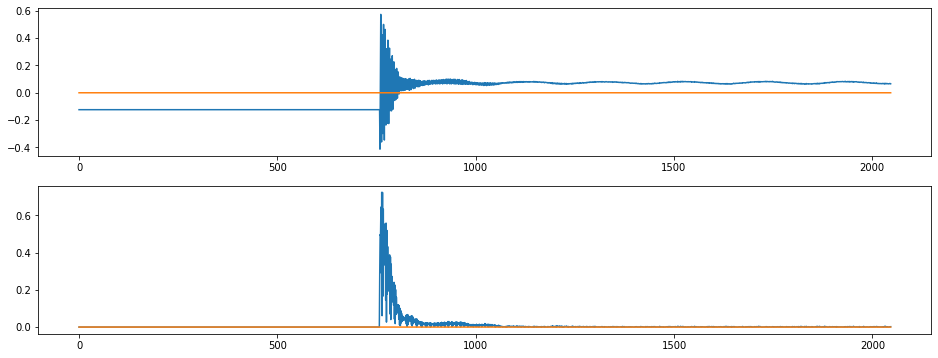

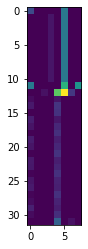

index:  67850
MAE:  0.09429628290270974
n_bunches       636
bunch_index     478
bunch_number    339
Name: 384397, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7242/instability_data/07242_Inst_B1H_Q7_20181001_08h27m29s.h5


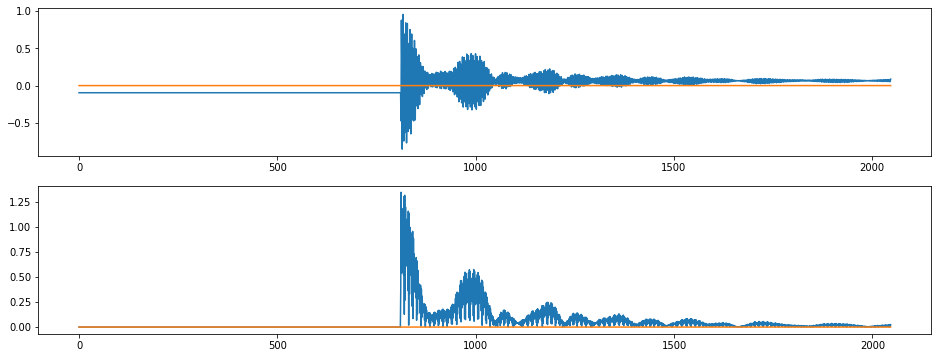

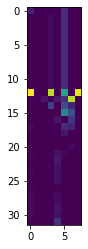

index:  40580
MAE:  0.09247267580225818
n_bunches       13
bunch_index      0
bunch_number     0
Name: 4331984, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7174/instability_data/07174_Inst_B1H_Q7_20180915_06h38m50s.h5


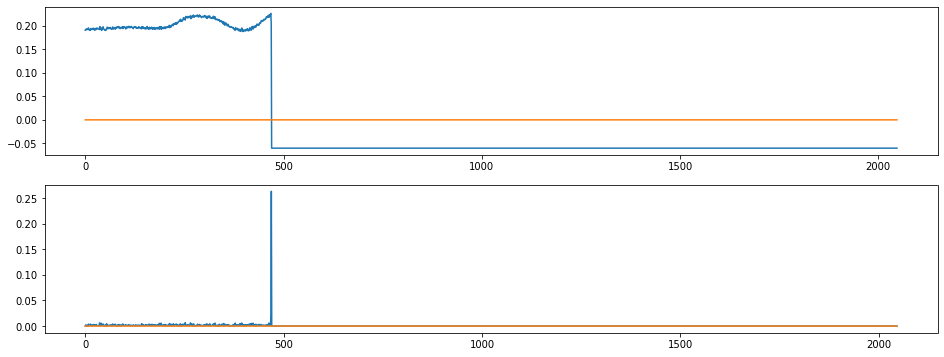

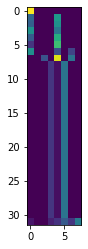

index:  367690
MAE:  0.08971362774112834
n_bunches       602
bunch_index     224
bunch_number     60
Name: 588611, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6929/instability_data/06929_Inst_B1H_Q7_20180716_03h25m14s.h5


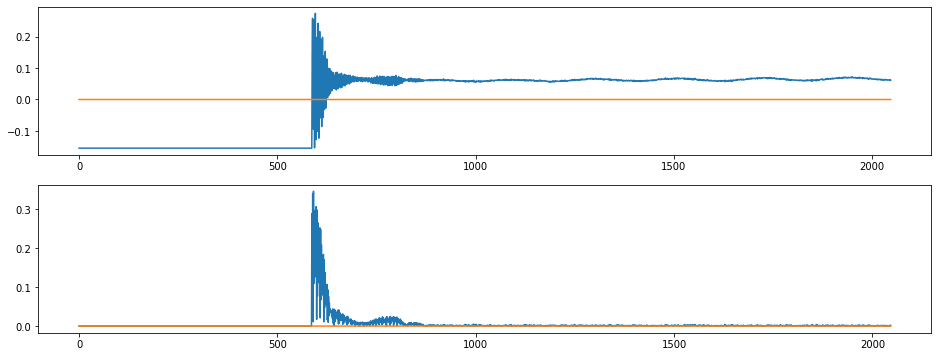

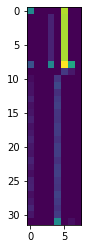

index:  141227
MAE:  0.08969304123530612
n_bunches       1868
bunch_index     2754
bunch_number    1479
Name: 5865962, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_23h39m14s.h5


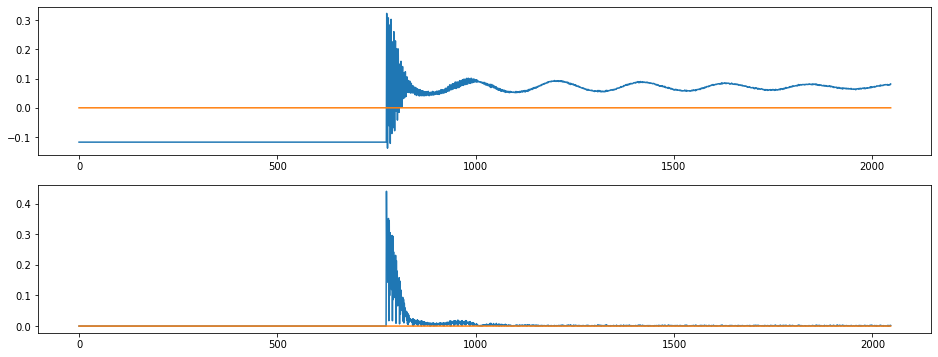

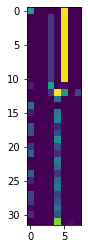

index:  40120
MAE:  0.08968843471182908
n_bunches       924
bunch_index     859
bunch_number    626
Name: 2261707, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7065/instability_data/07065_Inst_B1H_Q7_20180819_08h32m45s.h5


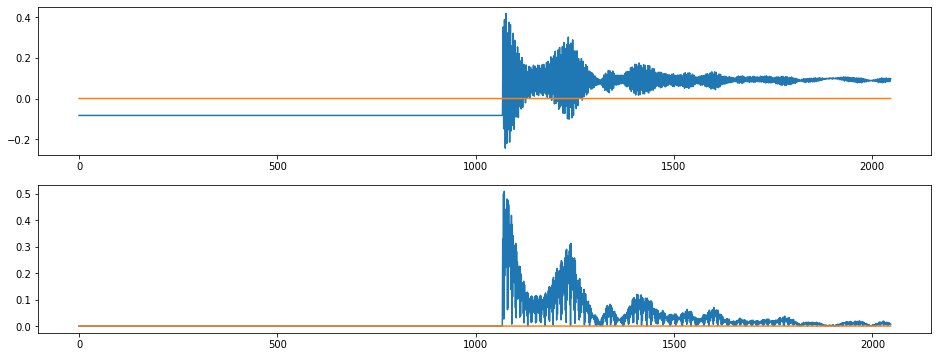

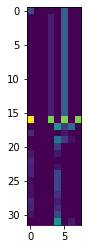

index:  263595
MAE:  0.08962639579272522
n_bunches       1068
bunch_index      289
bunch_number     176
Name: 11202946, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6760/instability_data/06760_Inst_B1H_Q7_20180605_16h00m51s.h5


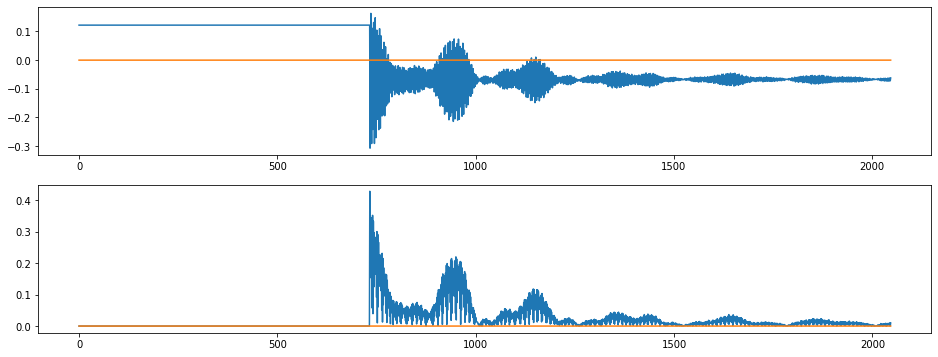

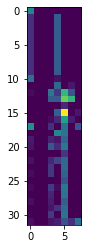

index:  31000
MAE:  0.0893106689734142
n_bunches       109
bunch_index     147
bunch_number     38
Name: 8120975, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6431/instability_data/06431_Inst_B1H_Q7_20171128_15h51m15s.h5


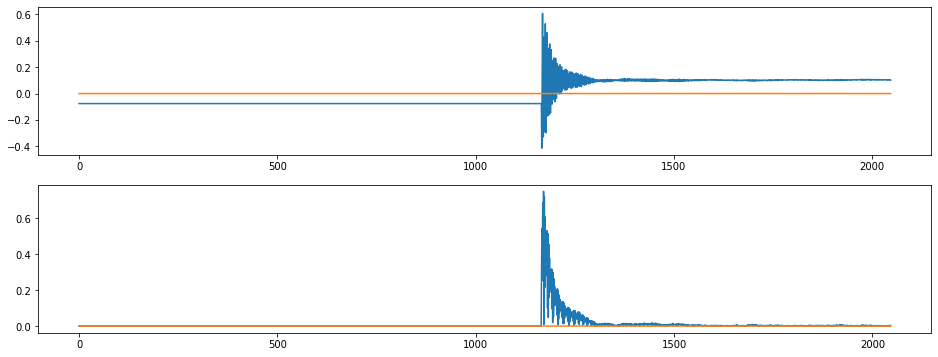

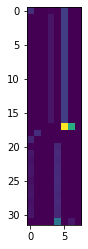

index:  119229
MAE:  0.08862296206928849
n_bunches       780
bunch_index     154
bunch_number     98
Name: 4467155, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7042/instability_data/07042_Inst_B1H_Q7_20180810_16h11m15s.h5


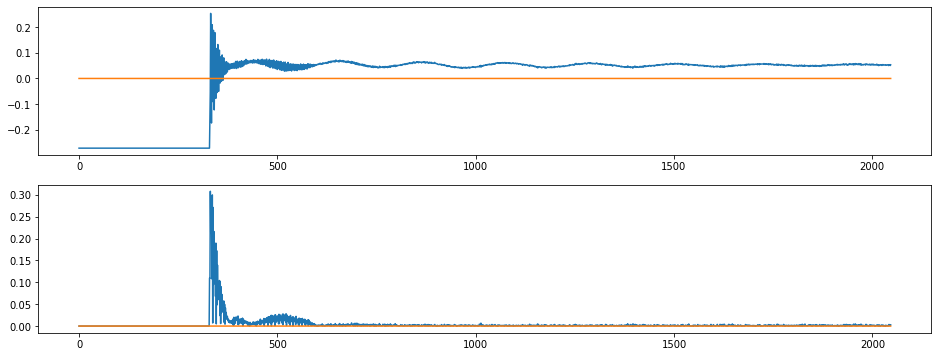

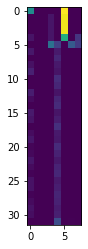

index:  289406
MAE:  0.0867087603282772
n_bunches       1836
bunch_index      431
bunch_number     215
Name: 1934462, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_04h38m13s.h5


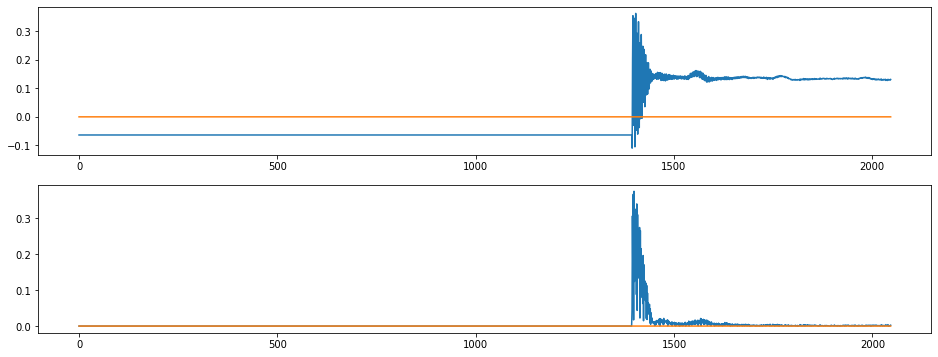

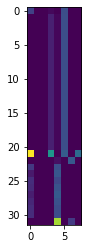

index:  110250
MAE:  0.08644204195208433
n_bunches       924
bunch_index     597
bunch_number    420
Name: 7750943, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6927/instability_data/06927_Inst_B1H_Q7_20180715_23h24m44s.h5


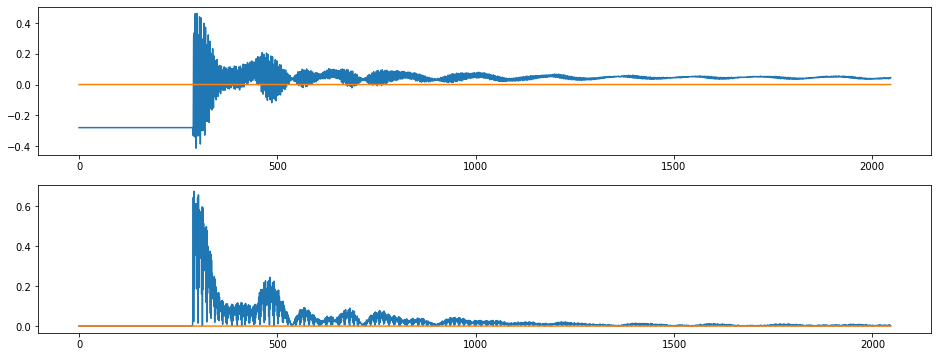

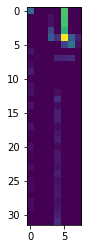

index:  328967
MAE:  0.08620899944375675
n_bunches       843
bunch_index     193
bunch_number     29
Name: 10369075, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6618/instability_data/06618_Inst_B1H_Q7_20180428_04h01m58s.h5


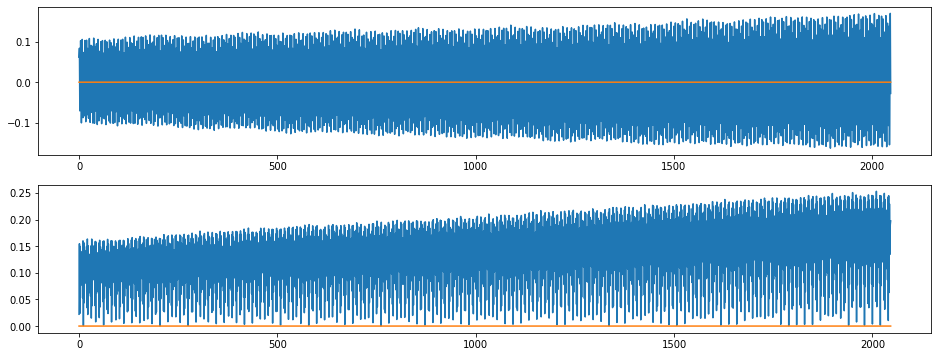

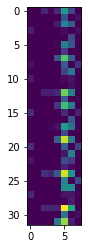

index:  28019
MAE:  0.08581916260095929
n_bunches       2556
bunch_index     1328
bunch_number     955
Name: 9149039, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_04h39m14s.h5


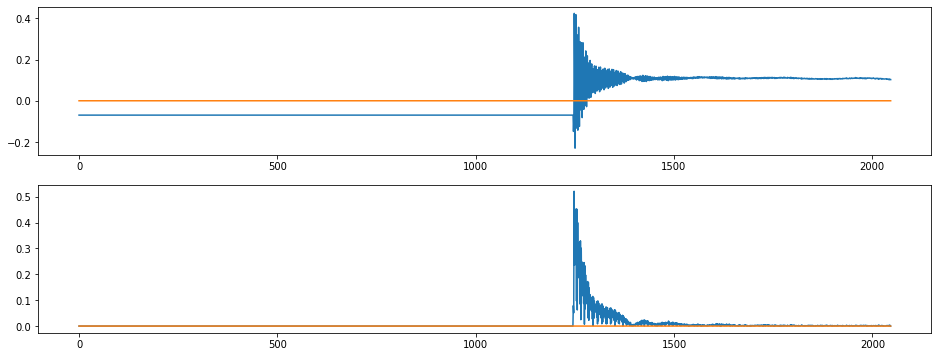

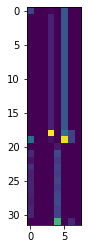

index:  348483
MAE:  0.08086118492061183
n_bunches       2556
bunch_index     2778
bunch_number    2044
Name: 9562689, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180521_01h01m14s.h5


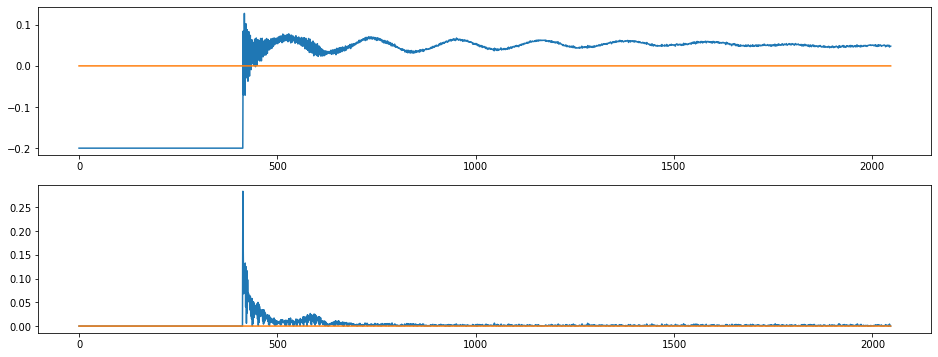

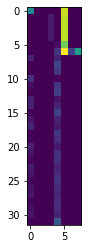

index:  44829
MAE:  0.08012971118765526
n_bunches       670
bunch_index     449
bunch_number     91
Name: 6273531, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_19h48m16s.h5


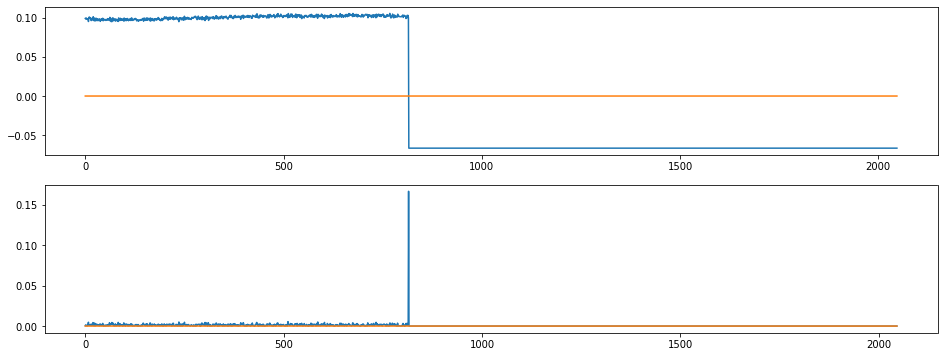

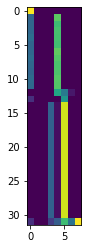

index:  193241
MAE:  0.07992165124359202
n_bunches       396
bunch_index     382
bunch_number    201
Name: 546219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_12h30m20s.h5


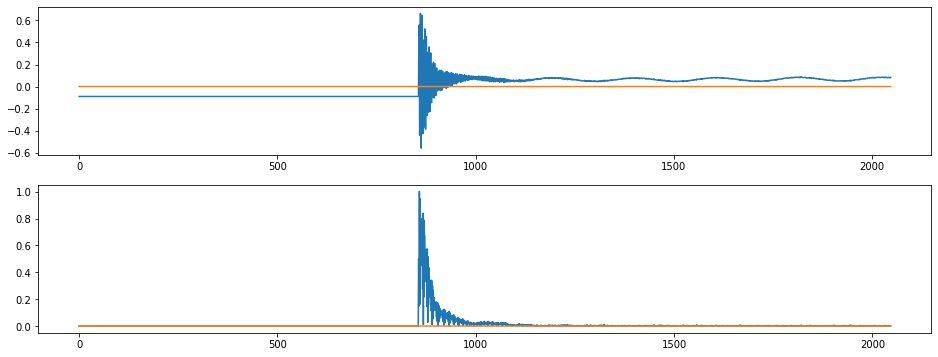

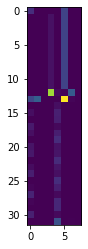

index:  114543
MAE:  0.07865292103716812
n_bunches       636
bunch_index     158
bunch_number     83
Name: 9669484, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6677/instability_data/06677_Inst_B1H_Q7_20180513_12h57m15s.h5


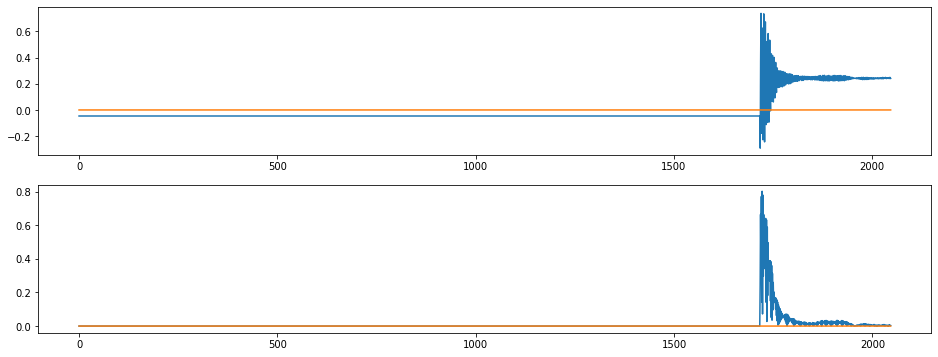

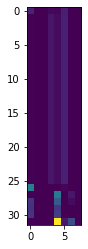

index:  158308
MAE:  0.07862162192566186
n_bunches       1068
bunch_index      941
bunch_number     677
Name: 660246, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7259/instability_data/07259_Inst_B1H_Q7_20181004_23h16m47s.h5


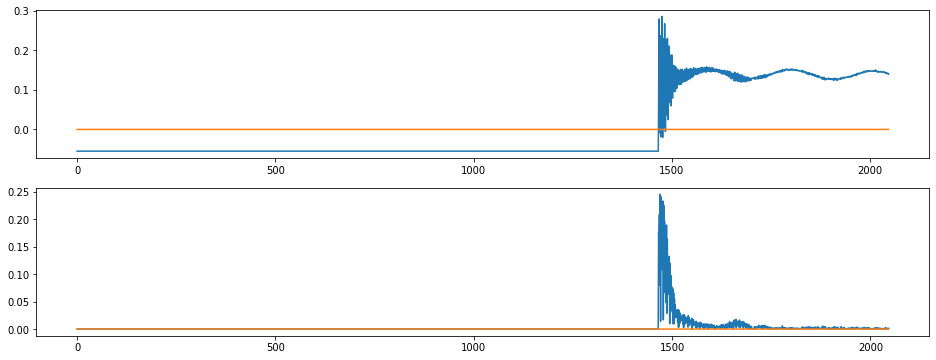

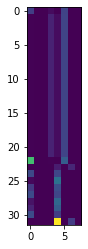

index:  259665
MAE:  0.07738910380130168
n_bunches       2175
bunch_index     2705
bunch_number    1730
Name: 1814901, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_12h11m13s.h5


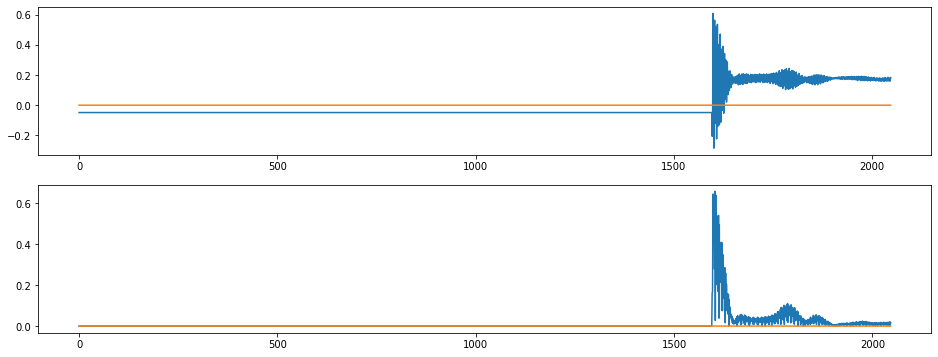

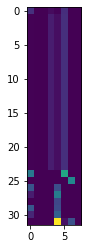

index:  149676
MAE:  0.07738109781763847
n_bunches       1358
bunch_index      552
bunch_number     238
Name: 7977027, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_05h04m23s.h5


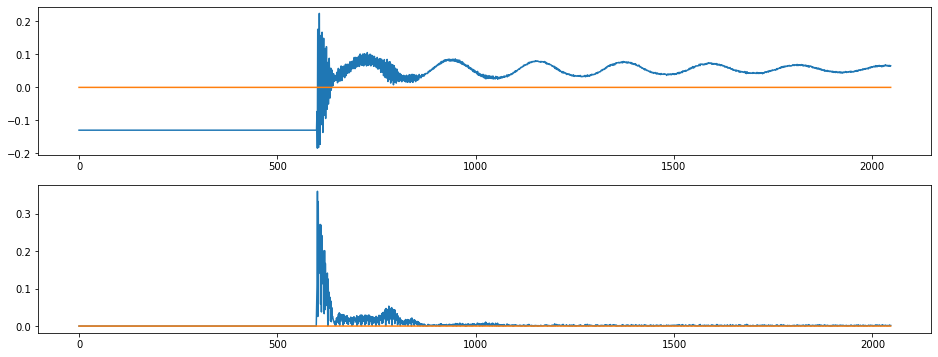

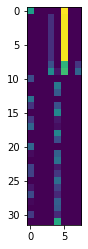

index:  291188
MAE:  0.07732762683144898
n_bunches       460
bunch_index      98
bunch_number     44
Name: 2071345, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170928_13h01m57s.h5


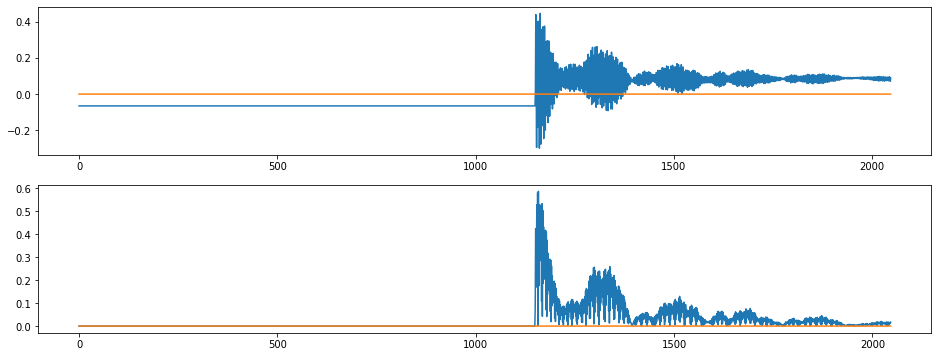

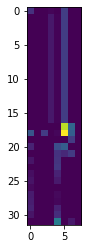

index:  28289
MAE:  0.07625325436934725
n_bunches       670
bunch_index     512
bunch_number    107
Name: 1798594, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_21h55m15s.h5


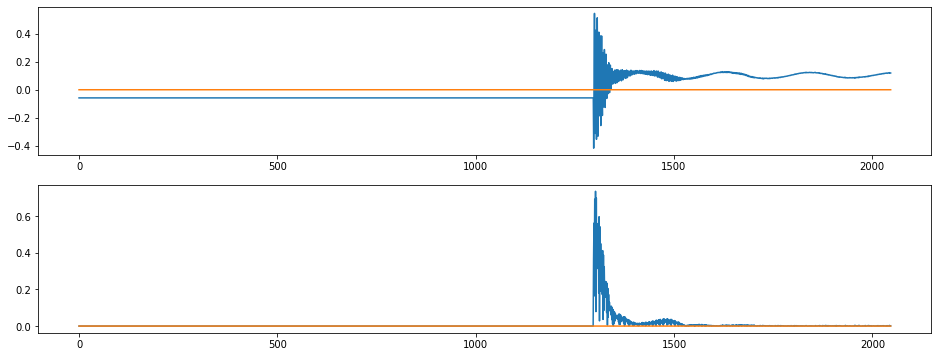

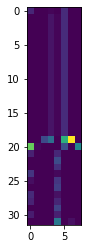

index:  375163
MAE:  0.07512185477885658
n_bunches       1916
bunch_index      899
bunch_number     482
Name: 1525292, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_07h20m15s.h5


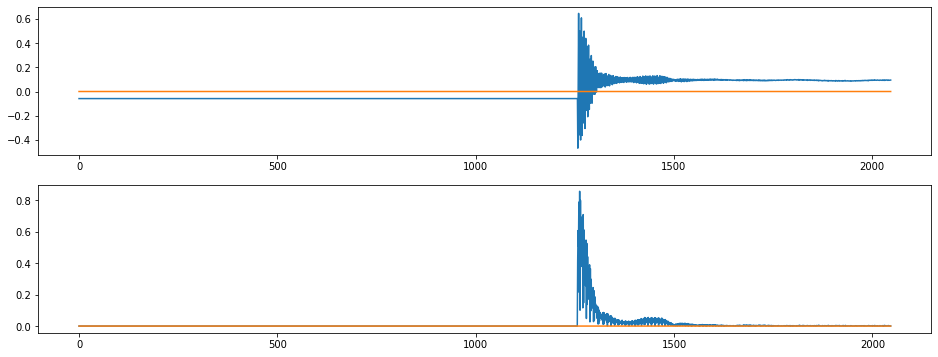

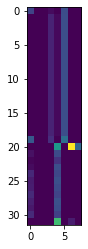

index:  210538
MAE:  0.07495186163786147
n_bunches       924
bunch_index     163
bunch_number     88
Name: 10727257, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6707/instability_data/06707_Inst_B1H_Q7_20180520_14h34m08s.h5


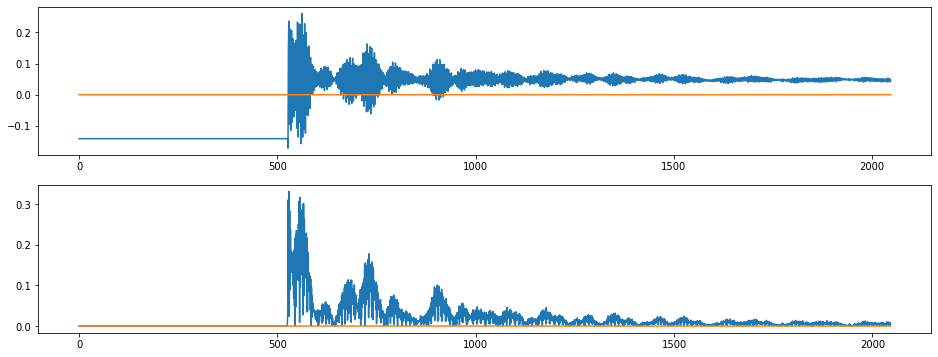

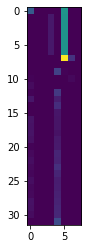

index:  61320
MAE:  0.0747143430393695
n_bunches       2556
bunch_index     2377
bunch_number    1762
Name: 8174808, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h53m13s.h5


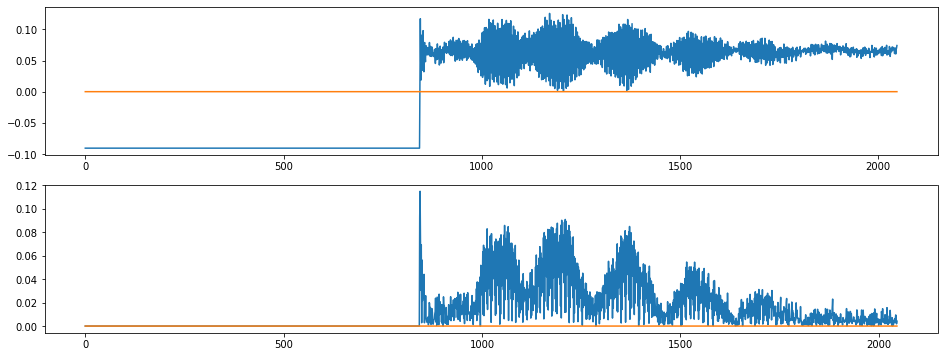

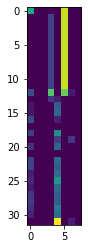

index:  328270
MAE:  0.07417319321720203
n_bunches       1380
bunch_index     1615
bunch_number    1314
Name: 3738057, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6600/instability_data/06600_Inst_B1H_Q7_20180423_13h36m39s.h5


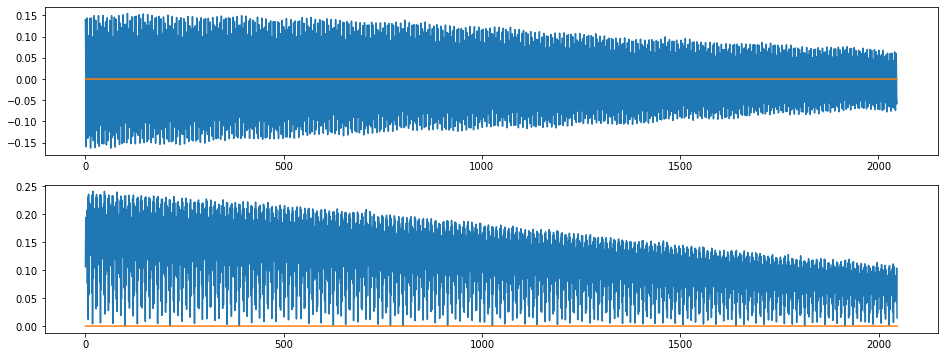

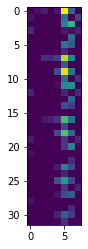

index:  57890
MAE:  0.07329766652368584
n_bunches       1836
bunch_index     1317
bunch_number     691
Name: 965401, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_07h36m14s.h5


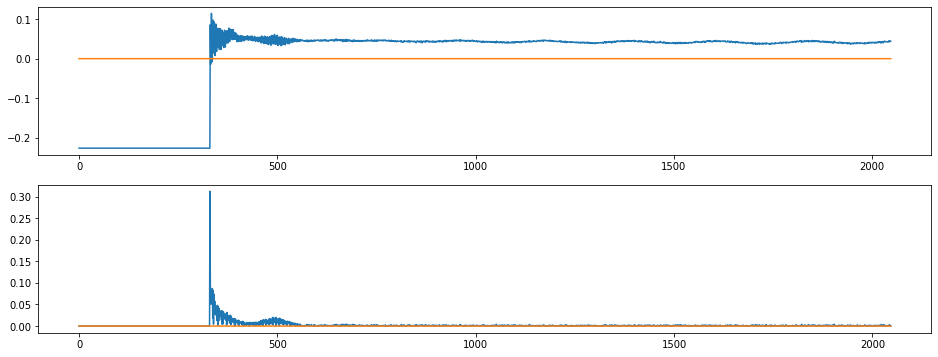

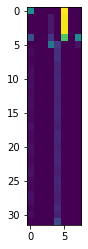

index:  408780
MAE:  0.07175435457264741
n_bunches       1868
bunch_index        3
bunch_number       3
Name: 4137521, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6344/instability_data/06344_Inst_B1H_Q7_20171029_02h03m14s.h5


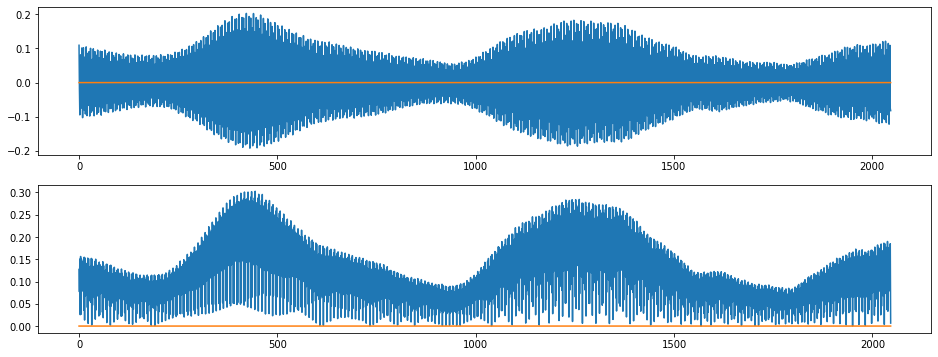

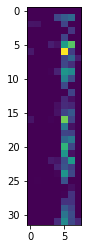

index:  80534
MAE:  0.07016430319545695
n_bunches       252
bunch_index     227
bunch_number    121
Name: 7550134, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6713/instability_data/06713_Inst_B1H_Q7_20180523_06h23m31s.h5


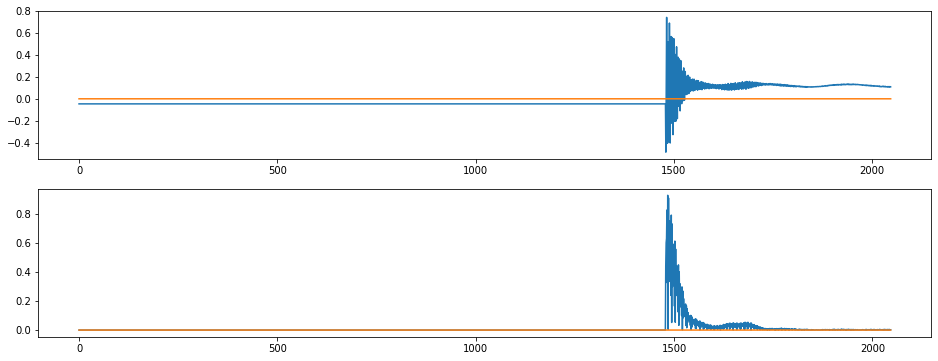

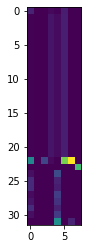

index:  313334
MAE:  0.06998894105238326
n_bunches        36
bunch_index     272
bunch_number     24
Name: 1034646, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6571/instability_data/06571_Inst_B1H_Q7_20180417_22h01m14s.h5


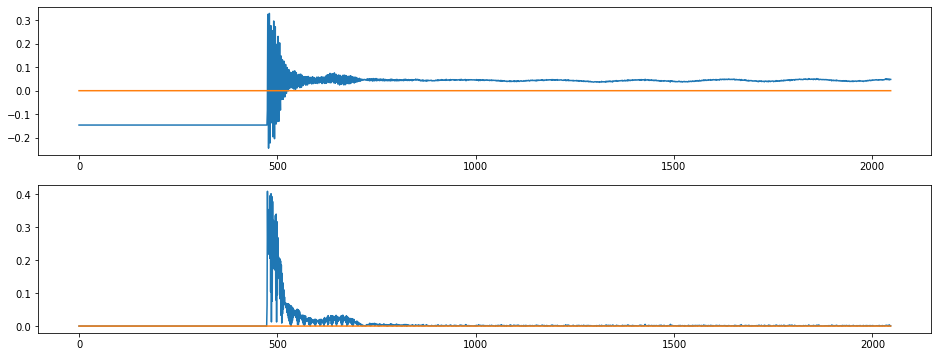

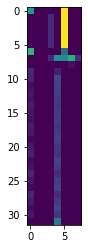

index:  334769
MAE:  0.06948962244934798
n_bunches        632
bunch_index     1821
bunch_number     330
Name: 7529913, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/instability_data/07442_Inst_B1H_Q7_20181113_21h31m16s.h5


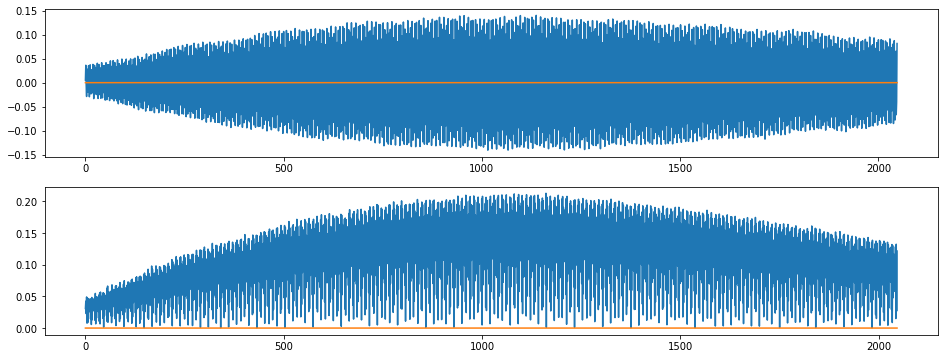

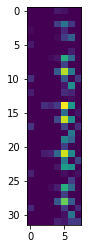

index:  338313
MAE:  0.06850897191101928
n_bunches        987
bunch_index     3164
bunch_number     883
Name: 8054386, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h11m14s.h5


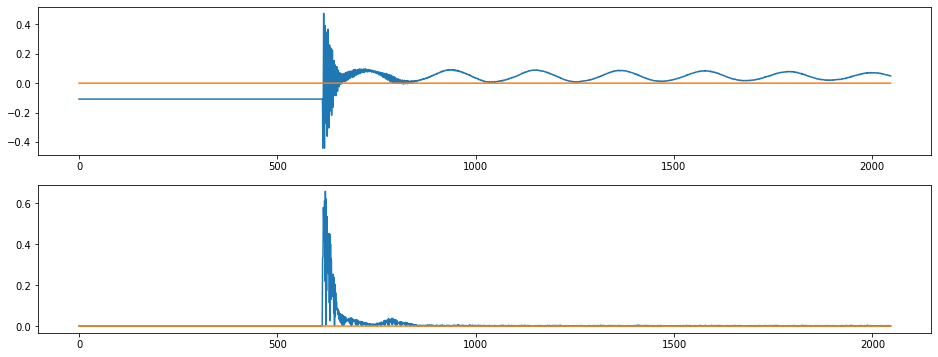

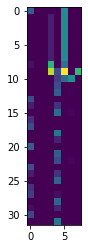

index:  351645
MAE:  0.06841839060423197
n_bunches       987
bunch_index     534
bunch_number    193
Name: 7219210, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_04h12m51s.h5


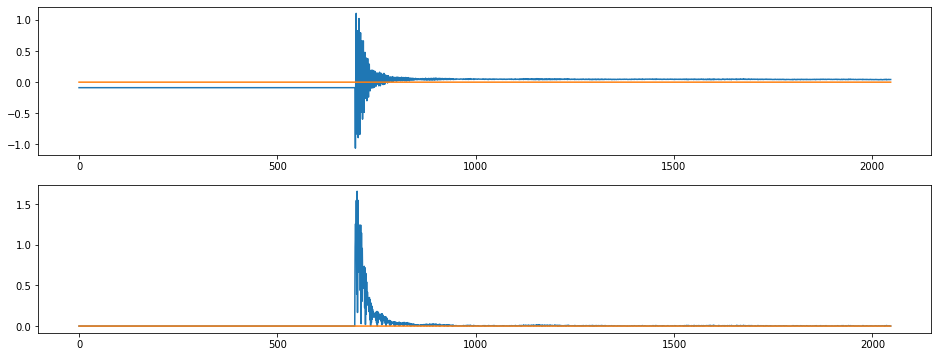

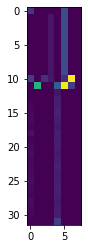

index:  406936
MAE:  0.06766657638461987
n_bunches        648
bunch_index     2796
bunch_number     522
Name: 5197438, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_10h18m15s.h5


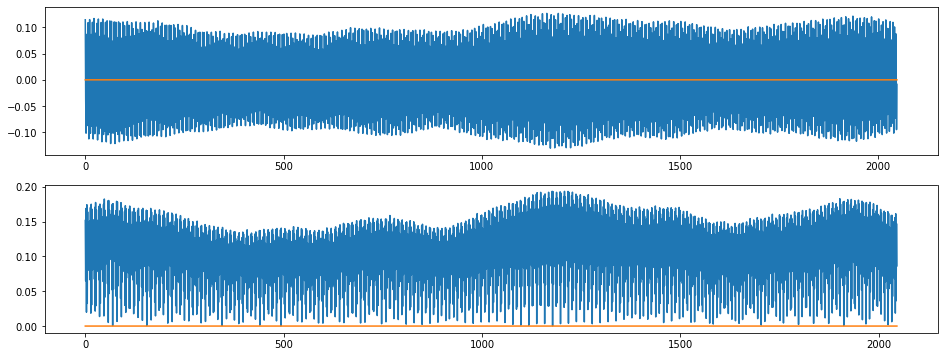

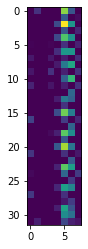

index:  385681
MAE:  0.06649878951673258
n_bunches       1068
bunch_index     1146
bunch_number     830
Name: 3874275, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7039/instability_data/07039_Inst_B1H_Q7_20180809_04h03m13s.h5


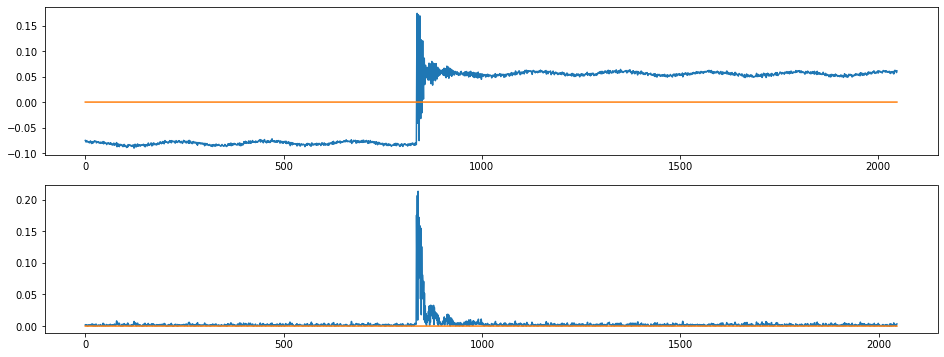

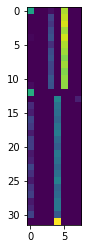

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()